# $ \text{Video Killed The Radio Star}$ $\color{red}{...Diffusion}$



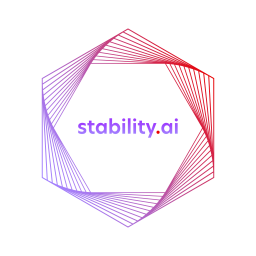

Notebook by David Marx ([@DigThatData](https://twitter.com/digthatdata))

Shared under MIT license

Last updated: 2023-06-15

Latest stable notebook revision: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dmarx/video-killed-the-radio-star/blob/main/Video_Killed_The_Radio_Star_Defusion.ipynb)

# Introduction

VKTRS is a tool for planning and generating complex animations using audio with spoken/sung words as conditioning input. The planning work can be used independently from generating an animation: all of your work is saved to a human-readable and modifiable `storyboard.yaml` file. Parameter names and notation are also compatible with other AI animation tools, such as a1111-deforum.

The inspiration for this notebook and the "variations" animation modes were  [this video](https://www.youtube.com/watch?v=WJaxFbdjm8c) created by Ben Gillin.

# General Workflow

If you are reading this in colab, open the "Table of contents" tab on the left sidebar for a more detailed enumeration of the steps described below.

1. Pick an audio source, like a youtube video
2. The notebook will download the video if necessary
3. OpenAI's "whisper" model is used to transcribe the lyrics
4. The timing of this transcription is used to segment the timeline into a sequence of "scenes"
5. The musical structure of the audio is analyzed to group thematically similar themes
6. Scene/theme specific settings (prompts, camera motion) can then be added
7. The audio can be further processed to isolate signals for driving animation parameters for "audioreactive" effects. This includes isolating instruments (demucs) and chaining manipulations (librosa)
8. Generate or specify starting images for each scene
9. Generate the remaining frames to animate each scene

**NB: the `img2img` animation mode is currently only supported when using the stability ai animation api (DreamStudio) to generate animations**. The audioreactivity features are currently only relevant in img2img mode. If you don't have a DreamStudio account, you can still use this notebook to parameterize an animation, you'll just need to cut-and-paste settings out of the "export settings" cell (deforum compatible) or the `storyboard.yaml` file.

# The "Storyboard"

Start at the top of the notebook and work your way down. Each decision you make contributes information to a file called "the storyboard", which persists project state. The notebook is designed to facilitate working iteratively: once you've made it past a given decision point, you should generally be able to jump back to that point to tweak whatever the decision was and return to where you were.

The storyboard isn't just a logical abstraction, it's a physical file you can modify directly, and is reasonably human readable.

Every project you start will create a new storyboard. If you set your project name to one you used previously, the notebook will attempt to find that project and load its storyboard.

The original motivation behind VKTRS was to be a toy for automating generative music videos. It has evolved quite a bit since, and I now mostly think about it as a tool for building and manipulating these storyboards. The storyboard parameterizes an animation, but the actual animation doesn't need to be generated by this tool.


# $\text{FAQ}$

**Why the name?**

The notebook's name is an ironic homage to the first music video played on MTV: [The Bugles - Video Killed The Radio Star](https://www.youtube.com/watch?v=W8r-tXRLazs). Quoting [wikipedia](https://en.wikipedia.org/wiki/Video_Killed_the_Radio_Star):

> "The song relates to concerns about, and mixed attitudes toward 20th-century inventions and machines for the media arts."

**Something didn't work quite right in the transcription process. How do fix the timing or the actual lyrics?**

The notebook is divided into several steps. Between each step, a "storyboard" file is updated. If you want to
make modifications, you can edit this file directly and those edits should be reflected when you next load the
file. Depending on what you changed and what step you run next, your changes may be ignored or even overwritten.
Still playing with different solutions here.

**Can I provide my own images to 'bring to life' and associate with certain lyrics/sequences?**

Yes, you can! As described above: you just need to modify the storyboard. Will describe this functionality in
greater detail after the implementation stabilizes a bit more.

**How can I support your work or work like it?**

This notebook was made possible thanks to ongoing support from [stability.ai](https://stability.ai/). The best way to support my work is to share it with your friends, [report bugs](https://github.com/dmarx/video-killed-the-radio-star/issues/new), [suggest features](https://github.com/dmarx/video-killed-the-radio-star/discussions) or to donate to open source non-profits :)

# Examples of content made with VKTRS

[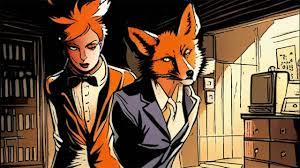](https://www.youtube.com/watch?v=dx8LmqalrmU)

**The Sudden - Fine (Official Music Video)** `variations` animation mode and theme prompts.

<div><a href="https://www.youtube.com/watch?v=ScbXSLYyzq4"><img src="https://i.ytimg.com/vi_webp/ScbXSLYyzq4/oar2.webp" alt="Hi-Standard - Asian Pride" width="300"/></a></div>

 **Hi-Standard - Asian Pride** `img2img` animation mode (via the Stability.AI animation API), with camera movement and simple audioreactivity (vocals stem driving `strength_curve` and `noise_curve`). This was one of my test animations and doesn't do the notebook justice, but you'll get the idea.



## $0.$ Setup

In [ ]:
# @title # 📊 Check GPU Status

import pandas as pd
import subprocess

def gpu_info():
    outv = subprocess.run([
        'nvidia-smi',
            # these lines concatenate into a single query string
            '--query-gpu='
            'timestamp,'
            'name,'
            'utilization.gpu,'
            'utilization.memory,'
            'memory.used,'
            'memory.free,'
            ,
        '--format=csv'
        ],
        stdout=subprocess.PIPE).stdout.decode('utf-8')

    header, rec = outv.split('\n')[:-1]
    return pd.DataFrame({' '.join(k.strip().split('.')).capitalize():v for k,v in zip(header.split(','), rec.split(','))}, index=[0]).T

gpu_info()

In [ ]:
#%%capture

# @title # 🛠️ Setup: Install Dependencies

# Install dependencies

try:
    import google.colab
    local=False
except:
    local=True

# TODO: pin versions

# local only additional dependencies
if local:
    %pip install pandas torch pillow beautifulsoup4 scipy toolz numpy lxml librosa scikit-learn rich

# dependencies for both colab and local
%pip install yt-dlp python-tsp stability-sdk[anim_ui] diffusers transformers ftfy accelerate omegaconf
%pip install openai-whisper panel huggingface_hub ipywidgets safetensors keyframed demucs parse

In [147]:
#%%capture

# @title # 🛠️ Setup: Imports and Definitions

#  Definitions and imports

import copy
import datetime as dt
import gc
import io
from itertools import chain, cycle
import json
import os
from pathlib import Path
import random
import re
import shutil
import string
import subprocess
from subprocess import Popen, PIPE
import time
import warnings

from bokeh.models.widgets.tables import (
    NumberFormatter,
    BooleanFormatter,
    CheckboxEditor,
)
from diffusers import (
    StableDiffusionImg2ImgPipeline,
    StableDiffusionPipeline,
)
from IPython.display import display
import keyframed
import keyframed as kf # TODO...
import keyframed.dsl
import librosa
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import panel as pn
import parse
import PIL
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
from python_tsp.exact import solve_tsp_dynamic_programming
import rich
from safetensors.numpy import save_file as save_safetensors
from safetensors.numpy import load_file as load_safetensors
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster
import textwrap
from tqdm.autonotebook import tqdm
import torch
from torch import autocast
import whisper

from stability_sdk.api import Context
from stability_sdk.animation import AnimationArgs, Animator

from stability_sdk.animation import (
    AnimationArgs,
    Animator,
    AnimationSettings,
    BasicSettings,
    CoherenceSettings,
    ColorSettings,
    DepthSettings,
    InpaintingSettings,
    Rendering3dSettings,
    CameraSettings,
    VideoInputSettings,
    VideoOutputSettings,
)

try:
    import google.colab
    local=False
except:
    local=True


def sanitize_folder_name(fp):
    outv = ''
    whitelist = string.ascii_letters + string.digits + '-_'
    for token in str(fp):
        if token not in whitelist:
            token = '-'
        outv += token
    return outv

# to do: is there a way to check if this is in the env already?
#pn.extension('tabulator')


def establish_workspace(
    use_stability_api,
    mount_gdrive,
    application_name="VideoKilledTheRadioStar",
    active_project=None,
):
    """
    This function constructs a local file called `config.yaml` that maintains state that will be used elsewhere.
    It mostly sets the names of project folders and a handful of settings. The reason for doing things this way
    is to facilitate "resume" functionality and creating new projects without overwriting previously created assets.

    By convention, when loaded the config.yaml is referred to as the `workspace` object.

    Most project-specific content will be located in a project-specific config -- `storyboard.yaml` -- which should be
    located in the folder path given by `workspace.project_root`. By convention, when loaded this is referred to as the
    `storyboard` object.

    If everything is set up correctly, you should be able to load the currently configured workspace and storyboard via:

        workspace, storyboard = load_storyboard()
    """
    # yeah... so... this shouldn't be necessary....
    import os

    # infer if we're on colab or not, since this impacts gdrive mounting
    try:
        import google.colab
        local=False
    except:
        local=True

    if local:
        mount_gdrive=False

    # Infer directory locations
    os.environ['XDG_CACHE_HOME'] = os.environ.get(
        'XDG_CACHE_HOME',
        str(Path('~/.cache').expanduser())
    )
    if mount_gdrive:
        from google.colab import drive
        drive.mount('/content/drive')
        Path('/content/drive/MyDrive/AI/models/.cache/').mkdir(parents=True, exist_ok=True)
        os.environ['XDG_CACHE_HOME']='/content/drive/MyDrive/AI/models/.cache'

    model_dir_str=str(Path(os.environ['XDG_CACHE_HOME']))
    proj_root_str = '${active_project}'
    application_root = str(Path('.').absolute())
    if mount_gdrive:
        application_root = '/content/drive/MyDrive/AI/VideoKilledTheRadioStar'


    # Build config file that defines the "workspace" abstraction
    workspace = OmegaConf.create({
        'active_project': active_project if active_project else str(time.time()),
        'application_root':application_root,
        'project_root':"${application_root}/${active_project}",
        'shared_assets_root':"${application_root}/shared_assets",
        'gdrive_mounted':mount_gdrive,
        'use_stability_api':use_stability_api,
        'model_dir':model_dir_str,
        'output_dir':'${project_root}/frames'
    })

    Path(workspace.project_root).mkdir(parents=True, exist_ok=True)
    Path(workspace.model_dir).mkdir(parents=True, exist_ok=True)
    Path(workspace.output_dir).mkdir(parents=True, exist_ok=True)

    ###################

    # Assign tracking locations for A/V assets and generally useful outputs

    assets_dir = Path(workspace.shared_assets_root)
    assets_dir.mkdir(parents=True, exist_ok=True)

    # TODO: yaml -> jsonl ?
    video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
    if not video_assets_meta_fname.exists():
        video_assets_meta = OmegaConf.create()
        video_assets_meta.videos = []
        with video_assets_meta_fname.open('w') as fp:
            OmegaConf.save(config=video_assets_meta, f=fp.name)
    else:
        video_assets_meta = OmegaConf.load(video_assets_meta_fname)

    audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
    if not audio_assets_meta_fname.exists():
        audio_assets_meta = OmegaConf.create()
        audio_assets_meta.content = []
        with audio_assets_meta_fname.open('w') as fp:
            OmegaConf.save(config=audio_assets_meta, f=fp.name)
    else:
        audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)

    ###################

    # Request user provide credentials as needed

    # if use_stability_api:
    #     import os, getpass
    #     if not os.environ.get('STABILITY_KEY'):
    #         os.environ['STABILITY_KEY'] = getpass.getpass('Enter your Stability API Key, then press enter to continue')
    # else:
    #     # TODO: check for HF token in environment
    #     if not local:
    #         from google.colab import output
    #         output.enable_custom_widget_manager()

    #     from huggingface_hub import notebook_login
    #     notebook_login()

    ###################

    with open('config.yaml','w') as fp:
        OmegaConf.save(config=workspace, f=fp.name)

    return workspace

########################

# wrap some of the loading logic for portability


def resolve_scene_ids_and_start_end_times(storyboard):
    """
    1. Force first scene to start at frame 0
    2. Force last scene to end in accordance with duration
    3. Force each scene's `end` attr to correspond to the `start` attr of the subsequent scene
    4. Force scene_id to correspond to scenes index position
    """
    storyboard.prompt_starts[0]['start']=0
    storyboard.prompt_starts[-1]['end']=max(storyboard.params.video_duration, storyboard.prompt_starts[-1]['end'])
    for idx, rec in enumerate(storyboard.prompt_starts):
        rec['scene_id']=idx
        if idx==0:
            prev_rec = rec
            continue
        prev_rec['end'] = rec['start']
    return storyboard

def save_storyboard(storyboard):
    resolve_scene_ids_and_start_end_times(storyboard)
    root = Path(load_workspace().project_root)
    root.mkdir(parents=True, exist_ok=True)
    storyboard_fname = root / 'storyboard.yaml'
    with open(storyboard_fname, 'w') as fp:
        OmegaConf.save(config=storyboard, f=fp.name)

def load_workspace():
    return OmegaConf.load('config.yaml')

def load_storyboard():
    workspace = load_workspace()
    root = Path(workspace.project_root)
    storyboard_fname = root / 'storyboard.yaml'
    storyboard = OmegaConf.load(storyboard_fname)
    return workspace, storyboard

def load_audio_meta(workspace, storyboard):
    assets_dir = Path(workspace.shared_assets_root)
    audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'
    audio_assets_meta = OmegaConf.load(audio_assets_meta_fname)
    audio_meta=dict()
    for idx, rec in enumerate(audio_assets_meta.content):
        if rec.audio_fpath == storyboard.params.audio_fpath:
            audio_meta = rec
            break
    return audio_meta

#######################

# EXTRA SEGMENTATION STUFF


def calculate_interword_gaps(segment):
    end_prev = -1
    gaps = []
    for word in segment['words']:
        if end_prev < 0:
            end_prev = word['end']
            continue
        gap = word['start'] - end_prev
        gaps.append(gap)
        end_prev = word['end']
    return gaps

def trivial_subsegmentation(segment, threshold=0, gaps=None):
    """
    split on gaps in detected vocal activity.
    Contiguity = gap between adjacent tokens is less than the input threshold.
    """
    if gaps is None:
        gaps = calculate_interword_gaps(seg)
    out_segments = []
    this_segment = [seg['words'][0]]
    for word, preceding_pause in zip(seg['words'][1:], gaps):
        if preceding_pause <= threshold:
            this_segment.append(word)
        else:
            out_segments.append(this_segment)
            this_segment = [word]
    out_segments.append(this_segment)

    outv = [dict(
        start=seg[0]['start'],
        end=seg[-1]['end'],
        text=''.join([w['word'] for w in seg]).strip(),
    ) for seg in out_segments]

    return outv

##############################################################

# audio processing


def analyze_audio_structure(
    audio_fpath,
    BINS_PER_OCTAVE = 12 * 3, # should be a multiple of twelve: https://github.com/MTG/essentia/blob/master/src/examples/python/tutorial_spectral_constantq-nsg.ipynb
    N_OCTAVES = 7,
):
    """
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    y, sr = librosa.load(audio_fpath)

    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                            bins_per_octave=BINS_PER_OCTAVE,
                                            n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                                ref=np.max)

    # reduce dimensionality via beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    Csync = librosa.util.sync(C, beats, aggregate=np.median)

    # I have concerns about this frame fixing operation
    beat_times = librosa.frames_to_time(librosa.util.fix_frames(beats, x_min=0), sr=sr)

    # width=3 prevents links within the same bar
    # mode=’affinity’ here implements S_rep (after Eq. 8)
    R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)
    # Enhance diagonals with a median filter (Equation 2)
    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    # build the sequence matrix (S_loc) using mfcc-similarity
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)
    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)
    # compute the balanced combination
    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)
    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)
    A = mu * Rf + (1 - mu) * R_path

    # compute normalized laplacian and its spectrum
    L = scipy.sparse.csgraph.laplacian(A, normed=True)
    evals, evecs = scipy.linalg.eigh(L)
    # clean this up with a median filter. can help smooth over discontinuities
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    return dict(
        y=y,
        sr=np.array(sr).astype(np.uint32),
        tempo=tempo,
        beats=beats,
        beat_times=beat_times,
        evecs=evecs,
    )


def laplacian_segmentation(
    audio_fpath=None,
    evecs=None,
    n_clusters = 5,
    n_spectral_features = None,
):
    """
    segment audio by clustering a self-similarity matrix.
    via librosa docs
    https://librosa.org/doc/latest/auto_examples/plot_segmentation.html#sphx-glr-auto-examples-plot-segmentation-py
    cites: McFee and Ellis, 2014 - https://brianmcfee.net/papers/ismir2014_spectral.pdf
    """
    if evecs is None:
        if audio_fpath is None:
            raise Exception("One of `audio_fpath` or `evecs` must be provided")
        features = analyze_audio_structure(audio_fpath)
        evecs = features['evecs']

    if n_clusters < 2:
        seg_ids = np.zeros(evecs.shape[0], dtype=int)
        return seg_ids

    if n_spectral_features is None:
        n_spectral_features = n_clusters

    # cumulative normalization is needed for symmetric normalize laplacian eigenvectors
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = n_spectral_features
    X = evecs[:, :k] / Cnorm[:, k-1:k]


    # use these k components to cluster beats into segments
    KM = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init="auto")
    seg_ids = KM.fit_predict(X)

    return seg_ids #, beat_times, tempo


# for video duration
def get_audio_duration_seconds(audio_fpath):
    outv = subprocess.run([
        'ffprobe'
        ,'-i',audio_fpath
        ,'-show_entries', 'format=duration'
        ,'-v','quiet'
        ,'-of','csv=p=0'
        ],
        stdout=subprocess.PIPE
        ).stdout.decode('utf-8')
    return float(outv.strip())


##########################################

# animation stuff

# TODO: update this stuff to reflect updates to API/sdk
def get_image_for_prompt_sai(prompt, max_retries=5, **kargs):
    stability_api = client.StabilityInference(
        key=os.environ['STABILITY_KEY'],
        verbose=False,
    )

    # auto-retry if mitigation triggered
    while max_retries:
        try:
            answers = stability_api.generate(prompt=prompt, **kargs)
            response = process_response(answers)
            for img in response:
                yield img
            break

        # TODO: better regen handling
        except RuntimeError:
            print("runtime error")
            max_retries -= 1
            warnings.warn(f"mitigation triggered, retries remaining: {max_retries}")

def process_response(answers):
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
                raise RuntimeError
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                yield img


########################################

# misc utils

def rand_str(n_char=5):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(n_char))

def save_frame(
    img: Image,
    idx:int=0,
    root_path=Path('./frames'),
    name=None,
):
    root_path.mkdir(parents=True, exist_ok=True)
    if name is None:
        name = rand_str()
    outpath = root_path / f"{idx}-{name}.png"
    img.save(outpath)
    return str(outpath)

def get_image_sequence(idx, root, init_first=True):
    root = Path(root)
    images = (root / 'frames' ).glob(f'{idx}-*.png')
    images = [str(fp) for fp in images]
    if init_first:
        init_image = None
        images2 = []
        for i, fp in enumerate(images):
            if 'anchor' in fp:
                init_image = fp
            else:
                images2.append(fp)
        if not init_image:
            try:
                init_image, images2 = images2[0], images2[1:]
                images = [init_image] + images2
            except IndexError:
                images = images2
    return images

def archive_images(idx, root, archive_root = None):
    root = Path(root)
    if archive_root is None:
        archive_root = root / 'archive'
    archive_root = Path(archive_root)
    archive_root.mkdir(parents=True, exist_ok=True)
    old_images = get_image_sequence(idx, root=root)
    if not old_images:
        return
    print(f"moving {len(old_images)} old images for scene {idx} to {archive_root}")
    for old_fp in old_images:
        old_fp = Path(old_fp)
        im_name = Path(old_fp.name)
        new_path = archive_root / im_name
        if new_path.exists():
            im_name = f"{im_name.stem}-{time.time()}{im_name.suffix}"
            new_path = archive_root / im_name
        old_fp.rename(new_path)


############################

# video compilation stuff

# TODO: Sorting algorithm that can tolerate more than 15-ish frames (GPU?)
def tsp_sort(frames):
    frames_m = np.array([np.array(f).ravel() for f in frames])
    dmat = pdist(frames_m, metric='cosine')
    dmat = squareform(dmat)
    permutation, _ = solve_tsp_dynamic_programming(dmat)
    return permutation

def add_caption2image(
      image,
      caption,
      text_font='LiberationSans-Regular.ttf',
      font_size=20,
      fill_color=(255, 255, 255),
      stroke_color=(0, 0, 0), #stroke_fill
      stroke_width=2,
      align='center',
      ):
    # via https://stackoverflow.com/a/59104505/819544
    wrapper = textwrap.TextWrapper(width=50)
    word_list = wrapper.wrap(text=caption)
    caption_new = ''
    for ii in word_list[:-1]:
        caption_new = caption_new + ii + '\n'
    caption_new += word_list[-1]

    draw = ImageDraw.Draw(image)

    # Download the Font and Replace the font with the font file.
    font = ImageFont.truetype(text_font, size=font_size)
    w,h = draw.textsize(caption_new, font=font, stroke_width=stroke_width)
    W,H = image.size
    x,y = 0.5*(W-w),0.90*H-h
    draw.text(
        (x,y),
        caption_new,
        font=font,
        fill=fill_color,
        stroke_fill=stroke_color,
        stroke_width=stroke_width,
        align=align,
    )

    return image

##########################################################

# audioreactivity stuff


def full_width_plot():
    ax = plt.gca()
    ax.figure.set_figwidth(20)
    plt.show()

def display_signal(y, sr, show_spec=True, title=None, start_time=0, end_time=9999):

#     if show_spec:
#         frame_time = librosa.samples_to_time(np.arange(len(normalized_signal)), sr=sr)
#     else:
#         frame_time = librosa.frames_to_time(np.arange(len(normalized_signal)), sr=sr)

    if show_spec:
        #librosa.display.waveshow(y, sr=sr)
        times = librosa.samples_to_time(np.arange(len(y)), sr=sr)
    else:
        #times = librosa.times_like(y, sr=sr).ravel()
        times = librosa.frames_to_time(np.arange(len(y)), sr=sr).ravel()

    start_idx = np.argmax(start_time <= times)
    #end_idx = len(times) - np.argmax([end_time <= times][::-1])
    end_idx = np.argmax(end_time <= times)
    if start_idx >= end_idx:
        end_idx = -1

    times = times[start_idx:end_idx]
    y = y[start_idx:end_idx]

    plt.plot(times, y)
    if title:
        plt.title(title)
    full_width_plot()
                      
    if show_spec:
        try:
            M = librosa.feature.melspectrogram(y=y, sr=sr)
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time')
            full_width_plot()

        except:
            pass

    # plt.plot(frame_time, y)
    # if title:
    #     plt.title(title)
    # full_width_plot()


# https://github.com/pytti-tools/pytti-core/blob/9e8568365cfdc123d2d2fbc20d676ca0f8715341/src/pytti/AudioParse.py#L95
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
    return sos

def butter_bandpass_filter(y, sr, lowcut, highcut, order=10):
    sos = butter_bandpass(lowcut, highcut, sr, order=order)
    y = sosfilt(sos, y)
    return y

########################################################################


def show_storyboard(storyboard=None):
    if storyboard is None:
        workspace, storyboard = load_storyboard()
    reactive_signal_map = {}
    if storyboard.get('audioreactive'):
        reactive_signal_map = storyboard.audioreactive.get('reactive_signal_map')

    for idx, rec in enumerate(storyboard.prompt_starts):
        report = f"scene: {idx}\t start: {rec['start']:.2f}"
        if rec.get('duration_'):
            report += f"\t duration: {rec.get('duration_'):.2f}"
        report += f"\nspoken text: {rec.get('text')}\n"

        # TODO: wrap prompt construction logic in a function (better yet use omegaconf substitution variables)

        #'_theme':'theme', 'structural_segmentation_label':
        if rec.get('_theme'):
            report += f"theme prompt: {rec['_theme']}\n"
        #f"image prompt: {rec['_prompt']}\n"
        prompt = rec.get('prompt')
        #if not prompt:
        #    prompt = ...
        if prompt:
            report += f"image prompt: {rec['_prompt']}\n"

        if rec.get('animation_mode'):
            report += f"animation mode: {rec['animation_mode']}"
        print(report)
        im_path = rec.get('frame0_fpath')
        if im_path and Path(im_path).exists():
            display(Image.open(rec['frame0_fpath']))

        if reactive_signal_map:
            n = rec['frames']
            if n <1:
                continue
            for signal_name in reactive_signal_map.keys():
                if signal_name in rec:
                    curve = kf.dsl.curve_from_cn_string(rec[signal_name])
                    xs = [i for i in range(n)]
                    ys = [curve[i] for i in xs]
                    plt.plot(xs, ys, label=signal_name)
                plt.title(f"scene {idx}")
                plt.xlabel("frame index within scene")
                plt.legend()
            plt.show()

#########################################

def get_path_to_stems():
    workspace, storyboard = load_storyboard()
    assets_root = Path(workspace.application_root) / 'shared_assets'
    #stems_path = root / "stems"
    stems_path = assets_root / "stems"
    stems_outpath = stems_path / 'htdemucs_ft' / Path(storyboard.params.audio_fpath).stem
    return stems_outpath

def ensure_stems_separated():
    stems_outpath = get_path_to_stems()
    stems_path = str(stems_outpath.parent.parent)
    if not stems_outpath.exists():
        !demucs -n htdemucs_ft -o "{stems_path}" "{storyboard.params.audio_fpath}"

def get_stem(instrument_name):
    ensure_stems_separated()
    stems_outpath = get_path_to_stems()
    stem_fpaths  = list(stems_outpath.glob('*.wav'))

    for stem_fpath in stem_fpaths:
        if instrument_name in str(stem_fpath):
            y, sr = librosa.load(stem_fpath)
            return y, sr
    raise ValueError(
        f"Unable to locate stem for instrument: {instrument_name}\n"
        f"in folder: {stems_outpath}"
    )


## 1. 📋💬 Build Base Storyboard
* Initial setup
* Infer keyframes for scene segmentation

In [ ]:
# @title ### 📋 Attach Storyboard (create or resume project)

project_name = 'newtest' # @param {type:'string'}

use_stability_api = False # @param {type:'boolean'}
mount_gdrive = True # @param {type:'boolean'}
resume=False # @param {type:'boolean'}

# TODO: add support for whisper API

# @markdown Enter a unique `project_name`.
# @markdown If left blank, the current unix timestamp will be used
# @markdown  (seconds since 1970-01-01 00:00).

# @markdown If you use the name of an existing project, the workspace will switch to that project (even if `resume` is unchecked. Each project needs a unique name).

# @markdown Non-alphanumeric characters (excluding '-' and '_') will be replaced with hyphens.

# @markdown ---

# @markdown # Detailed Discussion
# @markdown In VKTRS, a "project" is encapsulated by a folder.
# @markdown With google drive loaded, it will be the `<project_name>` subfolder under the path:
# @markdown `/content/drive/MyDrive/AI/VideoKilledTheRadioStar/`

# @markdown ---

# @markdown Depending on your settings and environment, running this cell may prompt you to enter one or more API Keys below.
# @markdown Don't forget to press "enter" after providing a requested key.


##########################

try:
    import google.colab
    local=False
except:
    local=True

if local:
    mount_gdrive=False


##################################################################

resuming = False
if resume:
    try:
        workspace, storyboard = load_storyboard()
        print("loading storyboard")
        resuming=True
    except:
        resuming = False

if not resuming:
    if not project_name:
        project_name = str(time.time())
    project_name = sanitize_folder_name(project_name)

    print("creating workspace")

    workspace = establish_workspace(
        use_stability_api=use_stability_api,
        mount_gdrive=mount_gdrive,
        application_name="VideoKilledTheRadioStar",
        active_project=project_name,
    )

    print("creating new storyboard")
    storyboard = OmegaConf.create()
    storyboard.params = {}

if workspace.use_stability_api:
    import os, getpass
    if not os.environ.get('STABILITY_KEY'):
        os.environ['STABILITY_KEY'] = getpass.getpass('Enter your Stability API Key, then press enter to continue')
else:
    # TODO: check for HF token in environment
    if not local:
        from google.colab import output
        output.enable_custom_widget_manager()

    from huggingface_hub import notebook_login
    notebook_login()

##################################################################

root = Path(workspace.project_root)

assets_dir = Path(workspace.shared_assets_root)

video_assets_meta_fname = assets_dir / 'video_assets_meta.yaml'
audio_assets_meta_fname = assets_dir / 'audio_assets_meta.yaml'

video_assets_meta = OmegaConf.load( assets_dir/'video_assets_meta.yaml' )
audio_assets_meta = OmegaConf.load( assets_dir/'audio_assets_meta.yaml' )

# just to be safe
save_storyboard(storyboard)
workspace, storyboard = load_storyboard()

import rich
rich.print(dict(workspace))

In [ ]:
# @title ⬇ Set Audio Source

d_ = dict(
    # all the underscore does is make it so each of the following lines can be preceded with a comma
    # otw the first parameter would be offset from the other in the colab form
    _=""

    , video_url = 'https://www.youtube.com/watch?v=REojIUxX4rw' # @param {type:'string'}
    , audio_fpath = '' # @param {type:'string'}
)
d_.pop('_')

# @markdown `video_url` - URL of a youtube video to download as a source for audio and potentially for text transcription as well.

# @markdown `audio_fpath` - Optionally provide an audio file instead of relying on a youtube download. Name it something other than 'audio.mp3',
# @markdown                 otherwise it might get overwritten accidentally.


storyboard.params = d_

storyboard_fname = root / 'storyboard.yaml'
with open(storyboard_fname,'wb') as fp:
    OmegaConf.save(config=storyboard, f=fp.name)


###############################
# Download audio from youtube #
###############################

# this should modify the existing record for the URL rather than creating a new one...
force_redownload=False

video_url = storyboard.params.video_url
download_video=True

if not force_redownload:
    for rec in video_assets_meta.videos:
        if rec.video_url == video_url:
            if rec.get('video_fpath'):
                print("previously downloaded video detected")
                download_video=False
                # populate storyboard with previous processing results
                if rec.get('audio_fpath'):
                    storyboard.params.audio_fpath = rec.get('audio_fpath')
            else:
                download_video=True # should be redundant?
            break



if download_video:
    # check if user provided an audio filepath (or we already have one from youtube) before attempting to download
    video_assets_meta_record = {}
    video_assets_meta_record['video_url'] = video_url

    ytdl_prefix = "DOWNLOADED__"
    ytdl_fname = f"{str(assets_dir / ytdl_prefix)}%(title)s.%(ext)s"

    !yt-dlp -o "{ytdl_fname}" {video_url}

    matched_files = assets_dir.glob(ytdl_prefix+"*")
    most_recent_file = max(matched_files, key=os.path.getctime)
    print(f"downloaded: {most_recent_file}")
    ytdl_fname = most_recent_file

    video_assets_meta_record['video_fpath'] = str(ytdl_fname.absolute())

    # TODO: right here, we should be adding this to the audio meta
    audio_fpath = ytdl_fname.with_suffix('.m4a')
    input_audio = ytdl_fname
    !ffmpeg -y -i "{input_audio}" -vn -c:a aac "{audio_fpath}"

    storyboard.params.audio_fpath = audio_fpath
    video_assets_meta_record['audio_fpath'] = str(audio_fpath.absolute())

    video_assets_meta.videos.append(video_assets_meta_record)


save_storyboard(storyboard)

with open(video_assets_meta_fname, 'wb') as fp:
    OmegaConf.save(config=video_assets_meta, f=fp.name)



In [ ]:
# @title ### 🔊 Initial Audio Processing

# @markdown * Transcribe and segment speech using whisper

# @markdown * Analyze major musical structure

# @markdown If this audio source has been previoussly processed by this notebook, that should be detected and processing won't be repeated.

##################################################
# 💬 Transcribe and segment speech using whisper #
##################################################

audio_fpath = str(storyboard.params.audio_fpath)

separate_stems = False # @param {type:'boolean'}

# these are just confusing i think
force_retranscription = False # #@#param {type:'boolean'}
override_storyboard_transcription = False # #@#param {type:'boolean'}

whisper_seg = None

if audio_fpath in audio_assets_meta:
    print("previously processed audio detected")
    audio_meta = audio_assets_meta[audio_fpath]
else:
    audio_assets_meta[audio_fpath] = {}
    audio_meta = audio_assets_meta[audio_fpath]

if (not force_retranscription) and audio_meta.get('whisper_segmentation') and Path(audio_meta.whisper_segmentation).exists():
    print("Using pre-existing whisper transcription")
    whisper_seg_fpath = Path(audio_meta.whisper_segmentation)
    with whisper_seg_fpath.open() as f:
        timings = json.load(f)
    whisper_seg = timings['segments']


if force_retranscription or (whisper_seg is None):
    print("Transcribing...")
    #audio_meta['audio_fpath'] = storyboard.params.audio_fpath redundant
    # outputs text files as audio.* locally
    !whisper --model large --word_timestamps True -o {str(assets_dir)} "{storyboard.params.audio_fpath}"

    whisper_seg_fpath = Path(storyboard.params.audio_fpath).with_suffix('.json')
    audio_meta['whisper_segmentation'] = str(whisper_seg_fpath)
    audio_meta['duration'] = get_audio_duration_seconds(audio_fpath)

    with whisper_seg_fpath.open() as f:
        timings = json.load(f)
    whisper_seg = timings['segments']

    audio_assets_meta[audio_fpath] = audio_meta
    with open(audio_assets_meta_fname, 'wb') as fp:
        OmegaConf.save(config=audio_assets_meta, f=fp.name)

if not storyboard.get('prompt_starts') or override_storyboard_transcription:

    # Ta da!
    storyboard.prompt_starts = [{k:rec[k] for k in ('start','end','text')} for rec in whisper_seg]

    storyboard.params['video_duration'] = audio_meta['duration']
    # unsure if below method is reliable.
    #storyboard.params['video_duration'] = storyboard.prompt_starts[-1]['end']


# TODO: enforce scene zero starts at t=0 and last scene ends at duration

#storyboard.prompt_starts = prompt_starts
save_storyboard(storyboard)

# Music Structure Analysis

# Music Structure Analysis
# - beat and tempo detection
# - Self-similarity graph

audio_structure_features = analyze_audio_structure(audio_fpath=storyboard.params.audio_fpath)

audio_features_fpath = Path(storyboard.params.audio_fpath).with_suffix('.audio_features.safetensors')
save_safetensors(audio_structure_features, audio_features_fpath)

# TODO: fix inconsistent variable naming
structural_features = audio_structure_features

# TODO: un-"PosixPath" `storyboard.params.audio_fpath`
# TODO: this is a confusing af way to access this.
audio_assets_meta[str(storyboard.params.audio_fpath)]['structural_features'] = audio_features_fpath


with open(audio_assets_meta_fname, 'wb') as fp:
    OmegaConf.save(config=audio_assets_meta, f=fp.name)

if separate_stems:
    ensure_stems_separated()

# TODO: ~PLACEHOLDER~ Give user opportunity to correct the transcription at shared_asset level rather than project


In [ ]:
# @title ### 🎞️ Show Current Storyboard
workspace, storyboard = load_storyboard() # just to ensure consistency
show_storyboard()

In [ ]:
# @title ### ✂️ Subdivide Unusually Long Scenes

# @markdown Attempts to identify unusually long scenes and splits them into multiple shorter scenes.
# @markdown Estimates the expected scene duration to identify outliers.

# TODO: wrap these steps in functions for legibility/portability
# TODO: make this threshold parameterizable via storyboard (and save analysis to storyboard)
# TODO: use beat counts to estimate a smart scene duration

subdivide_long_scenes = True # @param {'type':'boolean'}

#TODO: merge short scenes

# TODO: expose this to colab
threshold_duration = None

######################################################
# estimate parameters of scene duration distribution #
######################################################

# TODO: use beat onsets/counts
scene_durations = []
scenes_ = []
for idx, rec in enumerate(storyboard.prompt_starts):
    rec=dict(rec)
    if idx > 0:
        # are we maybe doubling up 'start' time stamps? like there are more unique 'end's than 'start's?
        duration = rec['start'] - prev['start']
        prev['duration_'] = duration
        scene_durations.append(duration)
    prev = rec
    scenes_.append(prev)

# handle last record
else:
    duration = rec['end'] - rec['start']
    rec['duration_'] = duration
    scenes_.append(rec)
    scene_durations.append(duration)

# handle case where there's only one scene
if idx == 0:
    duration = rec['end'] - rec['start']
    rec['duration_'] = duration
    scenes_.append(rec)
    scene_durations.append(duration)

mu = sum(scene_durations)/len(scene_durations)
sigma = np.std(scene_durations)

# 1sd filter to concentrate on mode
scene_durations2 = [s for s in scene_durations if (mu - sigma) < s < (mu+sigma)]
try:
    mu2 = sum(scene_durations2)/len(scene_durations2)
    sigma2 = np.std(scene_durations2)
    if mu2==0:
        subdivide_long_scenes=False
except ZeroDivisionError:
    subdivide_long_scenes = False
    warnings.warn(
        "Sorry, you've hit an unsupported edge case. "
        "We need some sort of segmentation to start with, but right now "
        "our initial heuristics have everything in one long scene. "
        "If you're trying to animate an instrumental track, VKTRS "
        "doesn't intelligent scene segmentation for that use case yet. "
        "Scene segmentation needs lyrics at the moment."
    )

###########

# break up "outlier" segments into smaller chunks
# this heuristic could be improved with beat synchronization and onset detection.
# ... also could probably leverage the 'end' time of the scene
# TODO: hierarchical theme structure analysis
# TODO: MSA segmentation for fully instrumental (i.e. arbitrary) audio

if subdivide_long_scenes:

    threshhold = mu2 + sigma
    if threshold_duration is not None:
        threshhold = threshold_duration

    scenes = []
    #for rec in storyboard.prompt_starts:
    for rec in list(scenes_):
        gap_remaining = rec['duration_']
        while gap_remaining > threshhold:
            #step = min(max(mu2-sigma, (np.random.normal() + mu2)*sigma), mu2+sigma)
            step=mu2
            step = float(step)
            # TODO: move duration computation somewhere that it will happen necessarily
            rec['duration_'] = step
            new_rec = copy.deepcopy(rec)
            new_rec['start'] = rec['start'] + step
            # TODO: deal with new value here
            #new_rec['end'] = ??
            new_rec['duration_'] = step
            ### maybe i could add a flag or something to clarify that this was an "inferred" subscene
            #new_rec['parent_scene'] = rec.get('uid') # something like this?
            new_rec['inferred_subscene'] = True # or this?

            scenes.append(rec)
            rec = new_rec
            gap_remaining -= step
        scenes.append(rec)

    storyboard.prompt_starts = scenes

# TODO: get last scene "end" from story duration

# TODO: compute duration regardless of extra segmentation

# TODO: add scene indices back to rec's to facilitate editing the text file

save_storyboard(storyboard)
show_storyboard(storyboard)

In [ ]:
# @title ### 🤓 Math

# @markdown Construct an initial estimate for how many frames will be needed for
# @markdown each scene, based on the scene start times and animation framerate.

# @markdown * `fps` - The desired framerate of the animation (frames per second).
# @markdown  * `animation_mode="img2img"` - We will generate an image for every frame, so higher fps will take longer but improves audioreactivity.
# @markdown  * `animation_mode="variations"` - We will only need to generate `n_variations` images per scene. The FPS setting only affects how the video will be compiled.
# @markdown   The fps and n_variations settings will interact to define the frequency of a visual pulsing effect, e.g.
# @markdown    * fps=12, n_variations=4 : the animation will appear to "pulse" 3 times per second as the sequence of image variations is cycled.

#################################################
# Math                                          #
#                                               #
#    This block computes how many frames are    #
#    needed for each segment based on the start #
#    times for each prompt                      #
#################################################

# TODO: move variations settings up here

# TODO: leverage previous beat detection, onsets, etc. for frame timings
# - TODO: isolated cells for calculating and suggesting parameters (fps, n_variations)

# TODO: experiment with tying instantaneous framerate to a music attribute (i.e. so motion can change speed mid animation)

fps = 30 # @param {type:'integer'}
storyboard.params.fps = fps

ifps = 1/fps

# estimate video end
if not storyboard.params.get('video_duration'):
    storyboard.params['video_duration'] = get_audio_duration_seconds(storyboard.params.audio_fpath)
video_duration = storyboard.params['video_duration']

# dummy prompt for last scene duration
prompt_starts = OmegaConf.to_container(storyboard.prompt_starts)
prompt_starts.append({'start':video_duration})

# TODO: do we still need anim_start? is that used in rendering?
# TODO: add per-frame timings to incorporate beat information
# make sure we respect the duration of the previous phrase
frame_start=0
prompt_starts[0]['anim_start']=frame_start
for i, rec in enumerate(prompt_starts[1:], start=1):
    rec_prev = prompt_starts[i-1]
    k=0
    while (rec_prev['anim_start'] + k*ifps) < rec['start']:
        k+=1
    k-=1
    rec_prev['frames'] = k
    rec_prev['anim_duration'] = k*ifps
    frame_start+=k*ifps
    rec['anim_start']=frame_start

# drop the dummy frame
prompt_starts = prompt_starts[:-1]

# TODO: given a 0 duration prompt, assume its duration is captured in the next prompt
#        and guesstimate a corrected prompt start time and duration
#      - or rather.. why are there ever sero duration prompts?


storyboard.prompt_starts = prompt_starts

save_storyboard(storyboard)



## $2.$ 🎥🌈 Define your animation's aesthetics

### 2.1 📋 Assign Themes to Scenes

In [ ]:


# @markdown `theme_prompt` - Text that will be appended to the end of each lyric, useful for e.g. applying a consistent aesthetic style.
# @markdown  To provide multiple themes (only one will be used per scene), separate theme prompts with the `|` (pipe) symbol.

# @markdown `infer_thematic_structure` - if False, themes will be rotated sequentially such that no two adjacent frames
# @markdown will use the same theme prompt (if multiple theme prompts were provided). If True, song structure analysis will cluster related scenes into as many groups as there are theme prompts to attempt to associate a visual themes with respective musical themes.

# @markdown The analysis runs quick. If you didn't understand that explanation, just try it both ways and you'll probably get the idea.

theme_prompt = 'zombie wedding | zombie dance party | zombies in love' # @param {type:'string'}

infer_thematic_structure = True # @param {type:'boolean'}

storyboard.params.theme_prompt = theme_prompt
themes = [prompt.strip() for prompt in theme_prompt.split('|') if prompt.strip()]

# communicate theme_id mappings
df_themes = pd.DataFrame({'theme prompt':themes})
df_themes.index.name="theme_id"

rich.print(df_themes)
print()

if (len(themes) > 1):
    if infer_thematic_structure:

        # audio_assets_meta[storyboard.params.audio_fpath]['structural_features']
        beat_times = audio_structure_features['beat_times']
        evecs = audio_structure_features['evecs']
        segment_labels = laplacian_segmentation(
            evecs=evecs,

            # TODO: publish these parameters to the user
            n_clusters=len(themes), # be sure to explain this is an upper bound, stochastic
            n_spectral_features=len(themes),
        )

        # beatsynch scene start times

        # TODO: swap out rec['end'] -> rec_prev['start'] here
        for rec in storyboard.prompt_starts:
            beat_indices = np.where((beat_times >= rec['start']) & (beat_times <= rec['end']))[0]
            segments_this_interval = segment_labels[beat_indices]
            if len(segments_this_interval) == 0:
                dominant_label = 0
            else:
                dominant_label = int(np.argmax(np.bincount(segments_this_interval)))
            rec['structural_segmentation_label'] = dominant_label
            rec['_theme'] = themes[dominant_label]
    else:
        for rec in storyboard.prompt_starts:
            rec['_theme'] = themes[idx % len(themes)]
else:
    for rec in storyboard.prompt_starts:
        rec['_theme'] = theme_prompt


save_storyboard(storyboard)

# TODO: show dataframe if no init images?
show_storyboard(storyboard)

In [ ]:
# @title #### 📝 (Optional) modify theme prompt without impacting structure label assignments

# @markdown Themes will be assigned to the `structural_segmentation` label that maps to their ordering
# @markdown in the theme prompt. To change which theme goes where, simply modify the order in which
# @markdown they appear in your prompt.

# @markdown **Why the second cell?** The procedure that assigns labels to themes
# @markdown has some randomness, so re-running the cell above with the same
# @markdown settings might produce a different order (i.e. a different theme-label assignment)

theme_prompt = 'rusted industrial machinery | kaiju robot CGI | paperclips! paperclips! |  robotics for beginners | rusted industrial machinery' # @param {type:'string'}

#####################################################

storyboard.params.theme_prompt = theme_prompt
themes = [prompt.strip() for prompt in theme_prompt.split('|') if prompt.strip()]

for rec in storyboard.prompt_starts:
    theme_idx = rec.get('structural_segmentation_label',0)
    rec['_theme'] = themes[theme_idx]

save_storyboard(storyboard)
show_storyboard(storyboard)

### 2.2 🎛️🎚️ Animation Settings

In [ ]:
# @title #### 🎚️ (Advanced) `img2img` Animation settings

# @markdown NB: Skip this cell if you're not using the `img2img` animation mode. Go directly to the next cell, "📌".

# TODO: let's move `variations` settings into their own dedicated area,
#       call this "`img2img` animation settings" or something like that instead

# @markdown Run This cell to reveal a multi-tab UI for specifying `img2img` animation settings. When you are happy with your settings,
# @markdown run the cell which follows this one to attach the settings you have selected to one or more scenes/themes.

# @markdown To reset values to default, simply re-run this cell.

# @markdown The `img2img` animation mode is currently only supported through the Stability.AI Animation API (i.e. DreamStudio API).
# @markdown The `img2img` animation parameters are mostly compatible with deforum: if you don't want to animate via the Stability.AI,
# @markdown you can still use this notebook to configure your animation and then port the relevant settings from the `storyboard.yaml`
# @markdown to your tool of choice.

if not workspace.use_stability_api:
    warnings.warn("img2img animation currently only supported if you're using the stability API")
    arg_objs=[]
else:


    # TODO: Move/add context to setup cell, and/or generation cells

    # @markdown To get your API key visit https://dreamstudio.ai/account
    STABILITY_HOST = "grpc.stability.ai:443" #@param {type:"string"}

    show_documentation = True # @param {type:'boolean'}


    ###################################

    STABILITY_KEY = os.environ.get('STABILITY_KEY')

    # Connect to Stability API
    context = Context(STABILITY_HOST, STABILITY_KEY)

    # Test the connection
    context.get_user_info()



    ###################

    args_generation = BasicSettings()
    args_animation = AnimationSettings()
    args_camera = CameraSettings()
    args_coherence = CoherenceSettings()
    args_color = ColorSettings()
    args_depth = DepthSettings()
    args_render_3d = Rendering3dSettings()
    args_inpaint = InpaintingSettings()
    args_vid_in = VideoInputSettings()
    args_vid_out = VideoOutputSettings()
    arg_objs = (
        args_generation,
        args_animation,
        args_camera,
        args_coherence,
        args_color,
        args_depth,
        args_render_3d,
        args_inpaint,
        args_vid_in,
        args_vid_out,
    )

    def _show_docs(component):
        cols = []
        for k, v in component.param.objects().items():
            if k == 'name':
                continue
            col = pn.Column(v, v.doc)
            cols.append(col)
        return pn.Column(*cols)

    def build(component):
        if show_documentation:
            component = _show_docs(component)
        return pn.Row(component, width=1000)

pn.extension()

pn.Tabs(*[(a.name[:-5], build(a)) for a in arg_objs])

### 2.3 📌 Attach settings to scenes

In [ ]:
# @markdown If using img2img animation, use this cell to specify which scenes the settings you provided above should apply to.

# @markdown Otherwise, you can ignore the cell above and just do everything here.

# @markdown ---

# @markdown `override_storyboard` - If settings conflict with values already set on the storyboard, the values on the storyboard will take priority.

# @markdown `scene_ids` - Comma separated list of integers specifying scenes to attach to.

# @markdown `theme_ids` - Comma separated list of integers specifying themes the animation parameters should be associated with.

# @markdown NB: both `scene_ids` and `theme_ids` are zero-indexed.

# @markdown If you're not sure what the appropriate scene/theme ids are that you want to reference, use the next cell to load and view the current storyboard state.

# CURRENT ARGS APPLY TO...

all_scenes = True # @param {'type':'boolean'}

scene_ids = '' # @param {'type':'string'}
theme_ids = '' # @param {'type':'string'}

override_storyboard = True # @param {'type':'boolean'}

# @markdown ---

# @markdown ## Animation Modes.
# @markdown * `static`: turns off animation, static image for duration of scene.
# @markdown * `variations`: injects a small bit of "life" into the image. Cheap and fast.
# @markdown * `variations tsp`: variations animation with frames reordered for smoother motion. Cheap and fast, but a tad slower.
# @markdown * `img2img`: Fancy deforum-esque animation, only supported for stability api at present. Neither cheap nor fast.
# #@markdown * `default`: `img2img` if stability api enabled,  `variations tsp` if not.

# oh baby `jittered init`
# markdown * `jittered init`: The VKTRS special! Sample a variation and use that as an init image for img2img. Basically built for audioreactivity
# to do --> combine this with a referring expression mask
# make sure animation is configured so we can curve prompts

animation_mode = 'variations' # @param ["static", "variations", "variations tsp", "img2img"]

# @markdown ---

# @markdown ## Parameters for `variations` Animation Modes

# TODO: these parameters should get set elsewhere. maybe with animation mode?

# @markdown `n_variations` - How many unique variations to generate for a given text prompt. This determines the frequency of the visual "pulsing" effect

# @markdown `image_consistency` - controls similarity between images generated by the prompt.
# @markdown - 0: ignore the init image
# @markdown - 1: true as possible to the init image

## @markdown `max_video_duration_in_seconds` - Early stopping if you don't want to generate a video the full duration of the provided audio. Default = 5min.


n_variations=8 # @param {type:'integer'}
image_consistency=0.72 # @param {type:"slider", min:0, max:1, step:0.01}

variations_settings = {
    'n_variations':n_variations,
    'image_consistency':image_consistency,
}


# let's try this:
#   - user specifies animation stuff in cell above
#   - then user comes down here and persists the animation settings either to every scene, or to specific scenes.
#   - scene specification can just be a list of numbers
#   - feels like this should be moved after init image generation. maybe push init image generation up to run right after theme prompts and scene count is finalized?

# TODO: add storyboard -> parsec converter

# TODO: PR to deforum for storyboard.yaml support

# TODO: allow user to constrain attention to specific parameters or sets of parameters to set

def param2json(args_obj):
    args = args_obj.param.serialize_parameters()
    args = json.loads(args)
    args.pop('name')
    return args

def collect_animation_args():
    if 'arg_objs' in globals():
        args_d = {}
        [args_d.update(a.param.values()) for a in arg_objs]
        args=AnimationArgs(**args_d)
    else:
        import warnings
        warnings.warn(
            "Looks like you're animating in img2img mode "
            "without having specified any animation parameters. "
            "Using SDK defaults. "
        )
        args = AnimationArgs()
    return param2json(args)


##########################

scene_ids = [int(v.strip()) for v in scene_ids.split(',') if v]
theme_ids = [int(v.strip()) for v in theme_ids.split(',') if v]

# build list of scenes args will apply to

applicable_scenes = []
if all_scenes:
    applicable_scenes = [idx for idx, _ in enumerate(storyboard.prompt_starts)]
else:
    applicable_scenes += scene_ids
    applicable_scenes += theme_ids

###---------------------------------###

animation_mode = animation_mode.lower()
if animation_mode == 'default':
    animation_mode = 'img2img' if workspace.use_stability_api else 'variations tsp'

###---------------------------------###

# apply args to appropriate scenes

for idx, rec in enumerate(storyboard.prompt_starts):
    if idx not in applicable_scenes:
        continue

    board_args = rec.get('animation_args')
    if board_args:
        board_args = OmegaConf.to_container(board_args) # coerce to dict

    new_args = collect_animation_args()
    if not override_storyboard:
        new_args.update(board_args)
        #variations_settings
    rec['animation_args'] = new_args
    rec.update(variations_settings)

    if override_storyboard or (not rec.get('animation_mode')):
        rec['animation_mode'] = animation_mode

    # oooo lookat me being fancy with custom code!
    #if (idx >=23) or idx ==16:
    #    rec['animation_mode'] = 'img2img'

save_storyboard(storyboard)

In [ ]:
# @title ### 🎞️ Show Current Storyboard
workspace, storyboard = load_storyboard() # just to ensure consistency
show_storyboard()

### 2.4 🎧📈 (Advanced) Audioreactivity

In [ ]:
# @title ### Choose a driving signal

audio_assets_meta  = load_audio_meta(*load_storyboard())
#structural_features = audio_assets_meta[str(storyboard.params.audio_fpath)]['structural_features']

driving_signal_name = "vocals stem" #@param ['audio input','user specified','vocals stem','bass stem','other stem','drum stem']

# TODO: test this
custom_signal_fpath = '' # @param {'type':'string'}

def get_user_specified_signal():
    y, sr = librosa.load(custom_signal_fpath)
    return y, sr

y = structural_features['y']
sr = structural_features['sr']

driving_signals = {
    'audio input': lambda: (y, sr),
    'user specified': get_user_specified_signal,
    'vocals stem':lambda: get_stem('vocals'),
    'bass stem':lambda: get_stem('bass'),
    'other stem':lambda: get_stem('other'),
    'drum stem':lambda: get_stem('drum'),
}

raw_driving_signal, sr = driving_signals[driving_signal_name]()
display_signal(raw_driving_signal, sr, title=driving_signal_name)

#### Manipulate the signal

In [ ]:
import numpy as np
from scipy import signal
from inspect import signature
from functools import partial
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
#sklearn_extra.cluster.KMedoids

# @markdown To apply multiple operations, separate manipulation names with a '|' or just re-run this cell.
# @markdown When you're satisfied, run the next cell to replace the loaded driving signal with the manipulated signal.

# @markdown **Tips**
# @markdown * Add manipulations one at a time, re-running this cell each time to see what the effect of each subsequent manipulation is and to figure out if you need to change settings before adding others.
# @markdown * Start by isolating the thing you're interested in, then finish by cleaning it up for animation.
# @markdown * The outputs of this process will be saved in `storyboard.yaml` and can be used in other AI animation tools such as deforum.

# @markdown ### Available Signal Manipulations
# @markdown NB: if a signal's name is followed by an asterisk (`*`), this means it modifies the signal's time domain. Only one time domain transformation per sequence is supported.

# @markdown NB: if a signal's name is followed by two asterisks (`**`), this means it can't be used after a time-domain modifying manipulation has been applied.
# @markdown * `rms`* - Root mean squared. Converts raw signal to signal power
# @markdown * `novelty`* - Estimates strength of sound event onsets.
# @markdown * `predominant_pulse`* - Combined estimate of beat timing and strength
# @markdown * `bandpass(low, high)`** - Isolate signal to frequencies between `[low, high]`
# @markdown * `harmonic`** - Isolate the harmonic component.
# @markdown * `percussive`** - Isolate the percussive component.
# @markdown * `sustain(k)` - Treats signal as a self-exciting process that decays slowly over a window of `k`. Smooths asymmetrically (to the right)
# @markdown * `stretch` - Increases gap between high and low amplitude signals. Alias for `pow(2)`
# @markdown * `smoosh` - Reduces gap between high and low amplitude signals. Alias for `pow(1/2)`
# @markdown * `pow(k)` - Raises signal to the power of k.
# @markdown * `normalize` - Transform signal to `[0,1]` range. This will always be the last step, even if you don't specify it.
# @markdown * `threshold(low)` - Zero the signal where amplitude is less than `low`
# @markdown * `clamp(high)` - Clamp the signal such that no values have amplitude greater than `high`
# @markdown * `modulo(k)` - Detects peaks in signal and returns only every Kth-peak
# @markdown * `quantize(k)` - Discretizes the signal into K unique values after clustering amplitudes.

# we can have some undocumented manipulations I think.
# too cluttered as it is.
# #@markdown * `raw` - no op
# #@markdown * `pow2` - Square the signal. Increases gap between high and low amplitude signals
# #@markdown * `sqrt` - Square root of signal. Reduces gap between high and low amplitude signals
# #@markdown * `smooth(k)` - Smoothes the waveworm, using a symmetric smoothing window of `k`. Bigger `k` = flatter signal


# signal_manipulations = 'bandpass(300, 500) | pow2 | pow2 | rms | pow2 | threshold(5e-6) ' # @param {'type':'string'}
signal_manipulations = 'harmonic | bandpass(300, 500) | rms | smoosh ' # @param {'type':'string'}

manipulations = [m.strip() for m in signal_manipulations.split('|') if m.strip()]


# @markdown ---

# @markdown Running this cell will produce a series of plots, one for each signal manipulation.
# @markdown It might be helpful to zoom in on a particular time window or scene.

# TODO: add scene division markers to audio plots
plotting_window_start_time = 4#0
plotting_window_end_time = 5#9999

# @markdown ---

# @markdown ### Audio EQ cheat sheet

# @markdown ![Audio EQ cheat sheet](https://i.pinimg.com/736x/4f/28/5e/4f285e3fbc5b6b6ea78638e58b2e3052.jpg)


# TODO: specify which transforms are available in spectral space vs. not


# trim/trim(q) -> y[y>quantile(y,.1)]
# that 4part way of parameterizing a wave... hit, sustain, decay,..?



# all operations must either have signature (y, sr) or return a function which does

# def rms(y, sr):
#     return librosa.feature.rms(y=y)

# def novelty(y, sr):
#     return librosa.onset.onset_strength(y, sr)

# def predominant_pulse(y, sr):
#     return librosa.beat.plp(y, sr)

def pow2(y, sr):
    return y**2

def sqrt(y, sr):
    return y**-2


# so... apparently `pow` is a python builtin. whoops. Meh, fuck it.
def _pow(k):
    def pow_(y, sr):
        return y**k
    return pow_

# def stretch(k=2):
#     return _pow(k)

# def smoosh(k=2):
#     return _pow(-k)

def stretch(y, sr):
    y = normalize(y, sr)
    return normalize(y**2, sr)

def smoosh(y, sr):
    y = normalize(y, sr)
    return normalize(y**.5, sr)

def normalize(y, sr):
    normalized_signal = np.abs(y).ravel()
    normalized_signal /= max(normalized_signal)
    return normalized_signal

######################################

def smooth(k=150):
    k=int(k)
    def smooth_(y, sr=None):
        win_smooth = signal.windows.hann(k)
        filtered = signal.convolve(y, win_smooth, mode='same') / sum(win_smooth)
        return filtered
    return smooth_

def sustain(k=500):
    k=int(k)
    def sustain_(y, sr=None):
        win_sustain = signal.windows.hann(2*k)
        win_sustain[:k]=0
        filtered = signal.convolve(y.ravel(), win_sustain, mode='same') / sum(win_sustain)
        return filtered
    return sustain_


# TODO: decay() - sustain with an exponential window

#####################333

def bandpass(low: float, high:float):
    return partial(butter_bandpass_filter, lowcut=low, highcut=high)

def threshold(low):
    def f(y, sr):
        y[y<low] = 0
        return y
    return f

def clamp(high):
    def f(y, sr):
        y[y>high] = high
        return y
    return f


###############################3


# def peak_detection(y, sr):
#     peaks, _ = find_peaks(y)
#     return peaks

# TODO: support offset, so user could e.g. take either every even or every odd peak.
def modulo(k=2, offset=0):
    #k=int(k)
    def modulo_(y, sr=None):
        #peaks = peak_detection(y, sr)
        peaks, _ = find_peaks(y)
        #selected_peaks = peaks[::k]  # Select every kth peak
        selected_peaks=[]
        for peak_index, peak in enumerate(peaks.ravel()):
            if (peak_index + offset) % k == 0:
                selected_peaks.append(peak)
        print(selected_peaks)
        selected_peaks = np.array(selected_peaks)
        new_signal = np.zeros_like(y)
        new_signal[selected_peaks] = y[selected_peaks]  # Build a new signal with only the selected peaks
        return new_signal
    return modulo_

#################################

# chatgpt wrote this, needs to be tested. also, i might want to use medoids rather than means



def quantize(k=1):
    k=int(k)
    # why doesn't it respect `k` in the closure scope? Works fine for modulo(). weird.
    #def quantize_(y, sr=None):
    def quantize_(y, sr=None, K=k):
        k=K
        # Remove zero values
        nonzero_values = y[y > 0].reshape(-1, 1)

        # If the number of nonzero values is less than k, reduce k
        if nonzero_values.shape[0] < k:
            k = nonzero_values.shape[0]

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(nonzero_values)

        # Replace each value with the centroid of its cluster
        print(f"cluster centers: {np.unique(kmeans.cluster_centers_)}")
        quantized_values = kmeans.cluster_centers_[kmeans.labels_].flatten()

        # Create a new signal
        quantized_signal = np.zeros_like(y)
        quantized_signal[y > 0] = quantized_values
        return quantized_signal
    return quantize_

#####################################3

# TODO: add ability for user to do stuff via idiomatic `keyframed` rather than convolving signals

# # TODO: add operations: slice/isolate, mute, shift_y/truncate/drop (subtract some value from amplitude)
simple_signal_operations = {
    'raw': lambda y, sr: y,
    ##########
    'rms': lambda y, sr: normalize(librosa.feature.rms(y=y).ravel(), sr),
    'novelty': librosa.onset.onset_strength,
    'predominant_pulse': librosa.beat.plp,
    'bandpass': bandpass,
    'harmonic': lambda y, sr: librosa.effects.harmonic(y=y),
    'percussive': lambda y, sr: librosa.effects.percussive(y=y),
    ##########
    'pow2': lambda y, sr: y**2,
    'stretch': stretch,
    'sqrt': sqrt,
    'smoosh': smoosh,
    'pow':_pow,
    #################
    'smooth': smooth,
    'sustain': sustain,
    # #########
    'normalize': normalize,
    'abs': lambda y, sr: np.abs(np.abs(y)),
    'threshold': threshold,
    'clamp': clamp,
    'modulo': modulo,
    'quantize':quantize,
}

def prepare_operation(op_str, operations=simple_signal_operations):
    op_str = op_str.replace(' ','') # make sure there are no spaces separating arguments
    for op_name, op in operations.items():
        if op_name == op_str:
            return op

    # if we're here, that should mean we have arguments to parse.
    for op_name, op in operations.items():
        if op_str.startswith(f"{op_name}("):
            break
    else: # if we're here, it means we never broke out of the `for` loop, i.e. couldn't find a matching op
        raise ValueError(f"{op_str} is not a supported operation. Supported operations: {[op_name for op in operations]}")

    arg_names = [p for p in signature(op).parameters]
    bracketed = ["{" + p + "}" for p in arg_names]
    template = f"{op_name}({','.join(bracketed)})"
    result = parse.parse(template, op_str)
    kargs = result.named
    kargs = {k:float(v) for k,v in kargs.items()} # coerce strings to floats
    return op(**kargs)


# reset processing
driving_signal_massaged = raw_driving_signal

# TODO: precompute time component, modify as needed.
#       - concretely, rms changes time domain from samples->frames.

# start by showing user the pre-transformation signal
display_signal(driving_signal_massaged, 
               sr, 
               title="Starting signal", 
               start_time=plotting_window_start_time,
               end_time=plotting_window_end_time,
              )

show_spec=True
windowed_manipulations = ['rms', 'novelty']
manipulation_history = [] # this is necessary because certain manipulations shouldn't be repeated or otw can collide w each other
for idx, manipulation in enumerate(manipulations):
    print(manipulation)
    if manipulation in windowed_manipulations:
        if show_spec:
            show_spec=False
        else:
            warnings.warn(f"transform {manipulation} collides with a transform we've already performed. Skipping.")
            continue

    f = prepare_operation(manipulation)
    try:
        driving_signal_massaged = f(y=driving_signal_massaged, sr=sr)
    except (TypeError, librosa.ParameterError) as e: # this is sort of gross but fuck it
        print(e)
        f=f()
        driving_signal_massaged = f(driving_signal_massaged, sr)

    display_signal(
        driving_signal_massaged, 
        sr, 
        title=f"{idx}, {manipulation}", 
        show_spec=show_spec,
       start_time=plotting_window_start_time,
       end_time=plotting_window_end_time,
    )
else:
    # finalize signal
    #driving_signal_massaged = np.abs(driving_signal_massaged).ravel()
    #driving_signal_massaged /= max(driving_signal_massaged)
    driving_signal_massaged = normalize(driving_signal_massaged, sr)
    display_signal(driving_signal_massaged, sr, title="Final, Full Driving Signal", show_spec=False)
    


#### Name and save the new driving signal so you can use it in the storyboard

ALL SIGNALS REGISTERED TO STORYBOARD:


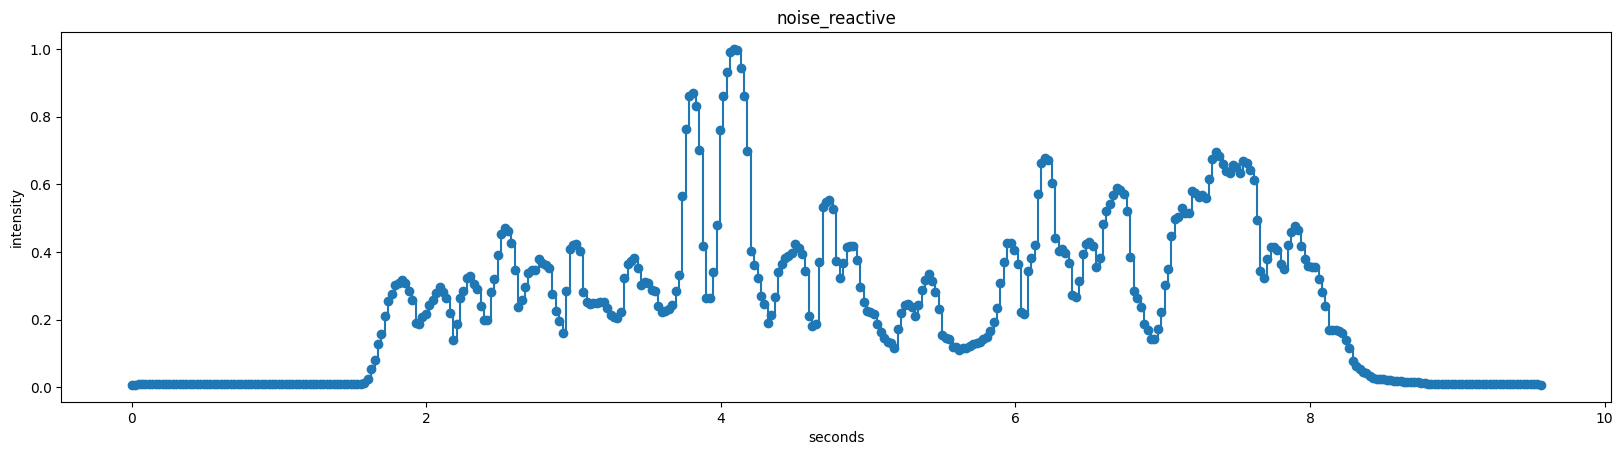

In [139]:
# @markdown When you're satisfied with the transformed signal, 
# @markdown give it a unique name to make it available to the storyboard.


import keyframed as kf


use_massaged_signal = True # @param {'type':'boolean'}

driving_signal = driving_signal_massaged if use_massaged_signal else raw_driving_signal

signal_name = 'noise_reactive' # @param {'type':'string'}

### Uncomment this snippet to write your driving signal to an audio file
#import soundfile
#soundfile.write('driving_signal.wav', driving_signal, sr)

#normalized_signal = np.abs(driving_signal).ravel()
#normalized_signal /= max(normalized_signal)

# TODO: manipulate the `frame_time` variable in synch with the signal. maybe track a "time_domain" variable ('frames'|'samples')

if show_spec: # TODO: need a better way to handle this
    frame_time = librosa.samples_to_time(np.arange(len(driving_signal)), sr=sr)
else:
    frame_time = librosa.frames_to_time(np.arange(len(driving_signal)), sr=sr)

driving_signal_kf = kf.Curve({t:v for t,v in zip(frame_time, driving_signal)}, label=signal_name)


#if not storyboard.get('audioreactive'):
#    storyboard.audioreactive = {'signals': [], 'reactive_signal_map': {}}

# fix bug from numpy dtypes
for rec in driving_signal_kf._data.values():
    rec.value = float(rec.value)
    rec.t = float(rec.t)
# fucking kill me...
driving_signal_kf._duration = float(driving_signal_kf.duration)

    
d_signal = driving_signal_kf.to_dict(simplify=False, for_yaml=True)

# TODO: parameter group?
if not storyboard.get('signals'):
    storyboard.signals = {}

storyboard.signals[signal_name] = d_signal

save_storyboard(storyboard)

from keyframed.serialization import from_dict as load_curve

print("ALL SIGNALS REGISTERED TO STORYBOARD:")

for sig_name, sig_curve in storyboard.signals.items():
    sig_curve = OmegaConf.to_container(sig_curve) # zomg...
    curve = load_curve(sig_curve)

    curve.plot()
    plt.xlabel('seconds')
    plt.ylabel('intensity')
    plt.title(f"{signal_name}")
    full_width_plot()

    
# plt.plot(frame_time, driving_signal)
# plt.xlabel('seconds')
# plt.ylabel('intensity')
# plt.title(f"Processed Audioreactivity Signal: {signal_name}")
# full_width_plot()

# #tot_frames = 
#curve_str = ','.join([f"{k:.04f}:({driving_signal_kf[k]:.04f})" for k in driving_signal_kf.keyframes])
#print(curve_str)

#### 3. Map the signals to parameters

In [175]:

signal_map =dict(
_=""
,target_parameter='noise_curve'
#,parameter_value="noise_reactive[t]"
#,param_max=0.06
#,param_min=0.03
,parameter_value="noise_reactive[t]*(.06-.03) + .03"
,param_max=1
,param_min=0
,invert_relationship_to_signal=False
)
signal_map.pop('_')


#signal_mappings = {
#    "noise_curve":"noise_reactive[t]*(.06-.03) + .03",
#}
signal_mappings[signal_map.pop('target_parameter')] = signal_map

#############################################################
curr_signal_mappings = storyboard.get('signal_mappings', defaultdict(dict))
curr_signal_mappings.update(signal_mappings)
storyboard.signal_mappings = dict(curr_signal_mappings)
save_storyboard(storyboard)

In [176]:
storyboard.signal_mappings

{'noise_curve': {'parameter_value': 'noise_reactive[t]*(.06-.03) + .03', 'param_max': 1, 'param_min': 0, 'invert_relationship_to_signal': False}}

In [153]:
import math
import numpy as np

def build_eval_scope(storyboard):
    # preload eval scope with math stuff
    math_env = {
        "abs": abs,
        "max": max,
        "min": min,
        "pow": pow,
        "round": round,
        "np": np,
        "__builtins__": None,
    }
    math_env.update(
        {key: getattr(math, key) for key in dir(math) if "_" not in key}
    )

    # add signals to scope
    for signal_name, sig_curve in storyboard.signals.items():
        sig_curve = OmegaConf.to_container(sig_curve) # zomg...
        curve = load_curve(sig_curve)
        math_env[signal_name] = curve
    return math_env


#eval(signal_mappings['noise_curve'], math_env, t=0)
math_env['t']=0
eval(signal_mappings['noise_curve'], math_env)

0.030208963360637425

In [229]:
def resolve_prompt(idx, storyboard):
    prompt_lag = storyboard.params.get("prompt_lag",True)
    rec = storyboard.prompt_starts[idx]
    if not rec.get('_prompt'):
        theme = rec.get('_theme')
        prompt = rec.get('prompt')
        if not prompt:
            prompt = f"{rec['text']}, {theme}"

            if prompt_lag and (idx > 0):
                rec_prev = storyboard.prompt_starts[idx -1]
                prev_text = rec_prev.get('text','')
                if not prev_text:
                    prev_text = rec_prev.get('prompt','').split(',')[0]
                this_text = rec.get('text','')
                if this_text:
                    prompt = f"{prev_text} {this_text}, {theme}"
                else:
                    prompt = rec_prev['_prompt']
        rec['_prompt'] = prompt


def compile_storyboard(storyboard=None, ignore_defaults=False):
    if storyboard is None:
        _, storyboard = load_storyboard()
    scenes = []
    story_defaults = storyboard.get('animation_args',{})
    for idx, rec in enumerate(storyboard.prompt_starts):
        
        # establish defaults
        scene_args=copy.deepcopy(story_defaults)
        if not ignore_defaults:
            scene_args = rec.get('animation_args',{})
        try:
            scene_args = OmegaConf.to_container(scene_args)
        except ValueError:
            pass

        # translate settings to deforum names
        resolve_prompt(idx, storyboard)
        scene_args['prompts'] = {"0":rec['_prompt']}
        scene_args['max_frames'] = rec['frames']
            
        # resolve signals
        default_mappings = storyboard.get('signal_mappings',{})
        signal_mappings = rec.get('signal_mappings', default_mappings)

        for param_name, param_meta in signal_mappings.items():
            param_expr, attr_hi, attr_low = param_meta['parameter_value'], param_meta['param_max'], param_meta['param_min']
            curve_chunks = []
            start=rec['start']
            for frame_idx in range(rec['frames']):
                curr_time = start + frame_idx * ifps
                math_env['t'] = curr_time
                signal_value=eval(param_expr, math_env)
                #if inverse_relationship:
                if param_meta['invert_relationship_to_signal']:
                    signal_value = 1-signal_value
                attr_value = signal_value*(attr_hi-attr_low)+attr_low
                curve_chunks.append(f"{frame_idx}: ({attr_value})")
            curve_str = ', '.join(curve_chunks)
            scene_args[param_name] = curve_str
            #scene_args = OmegaConf.to_container(scene_args)
        scenes.append(scene_args)
    return scenes

# TODO: copy init images into this folder, add to settings.txt's



def make_compatible_for_deforum(settings):
    fields_mapping={
        'prompts':'prompts',
        'fps':'fs',
        'extract_nth_frame':'extract_nth_frame',
        'angle':'angle',
        'zoom':'zoom',
        'translation_x': 'translation_x',
        'translation_y': 'translation_y',
        'translation_z': 'translation_z',
        'rotation_x': 'rotation_3d_x',
        'rotation_y': 'rotation_3d_y',
        'rotation_z': 'rotation_3d_z',
        'max_frames':'max_frames',
        #'noise_add_curve':'noise_schedule',
        'noise_curve':'noise_schedule',
        'noise_scale_curve':'noise_multiplier_curve',
        'strength_curve':'strength_schedule',
        'steps_curve':'steps_schedule',
        'srength_curve': 'strength_schedule',
        'steps_curve': 'steps_schedule',
    }
    # SAI_scalars_2_deforum_curves = {
    #     'cfg_scale':'cfg_scale_schedule',
    #     'seed':'seed_schedule',
    # }
    #keep_params = set(fields_mapping) + set(SAI_scalars_2_deforum_curves)
    
    outv = {}
    for k,v in settings.items():
        if k in fields_mapping:
            outv[fields_mapping[k]] = v
        elif k == 'cfg_scale':
            outv['cfg_scale_schedule'] = f"0: ({v})"
        elif k == 'seed':
            if v == -1:
                outv['seed_schedule'] = "0: (-1)"
            else:
                seed_schedule_chunks = []
                for i in range(settings['max_frames']):
                    #if v == -1:
                    #    v = random.randrange(0, 4294967295)
                    seed_schedule_chunks.append(f"{i}: ({v})")
                    v+=1
                outv['seed_schedule'] = ', '.join(seed_schedule_chunks)
    return outv
            
    
deforum_settings_root = Path(workspace.project_root) / "deforum_settings"
deforum_settings_root.mkdir(parents=True, exist_ok=True)

for idx, scene in enumerate(compile_storyboard(ignore_defaults=True)):
    scene = make_compatible_for_deforum(scene)
    fpath = deforum_settings_root / f"scene_{idx}_settings.txt"
    with fpath.open('w') as f:
        json.dump(scene, f)
    print(fpath)
    rich.print(scene)
    print()

/home/dmarx/projects/video-killed-the-radio-star/newtest/deforum_settings/scene_0_settings.txt


{
    'prompts': {
        '0': " Why can't people understand? I got a short attention span. Short attention span., rusted industrial 
machinery"
    },
    'max_frames': 287,
    'noise_schedule': '0: (0.030208963360637425), 1: (0.030237160893157124), 2: (0.03025829192250967), 3: 
(0.030267787417396903), 4: (0.030268083103001116), 5: (0.03026743666268885), 6: (0.030267514614388345), 7: 
(0.030268150661140678), 8: (0.030268664862960575), 9: (0.030269080325961113), 10: (0.030269473129883408), 11: 
(0.030269589694216847), 12: (0.030269743027165532), 13: (0.030270010996609927), 14: (0.030271365344524383), 15: 
(0.030272442838177083), 16: (0.030273259487003087), 17: (0.030273419972509145), 18: (0.030272817984223363), 19: 
(0.030272327642887828), 20: (0.030272634364664555), 21: (0.030273553831502795), 22: (0.030273770419880747), 23: 
(0.03027399642392993), 24: (0.03027392012067139), 25: (0.03027392101474106), 26: (0.03027362773194909), 27: 
(0.03027386569418013), 28: (0.03027330528013408), 29: (0.030272811893373726), 30: (0.030272741122171282), 31: 
(0.030273560788482427), 32: (0.030274588940665124), 33: (0.030275619328022002), 34: (0.0302754099201411), 35: 
(0.030274244053289292), 36: (0.030274089574813843), 37: (0.03027385720051825), 38: (0.030273557631298898), 39: 
(0.03027350661344826), 40: (0.030275809932500123), 41: (0.030277581475675105), 42: (0.030277795158326626), 43: 
(0.03027232093736529), 44: (0.03028241948224604), 45: (0.030292188338935374), 46: (0.0303311831317842), 47: 
(0.030330609390512107), 48: (0.030338736260309813), 49: (0.03158316191285848), 50: (0.032384232357144355), 51: 
(0.03469688773155212), 52: (0.036335900723934174), 53: (0.03830855548381805), 54: (0.03909123837947845), 55: 
(0.0392670214176178), 56: (0.03924838453531265), 57: (0.03850072771310806), 58: (0.03573555707931518), 59: 
(0.03559480369091034), 60: (0.03648601546883583), 61: (0.03731841668486595), 62: (0.03835395634174347), 63: 
(0.03887170046567917), 64: (0.03847023457288742), 65: (0.0366076049208641), 66: (0.03419268250465393), 67: 
(0.037899135053157805), 68: (0.038530772924423216), 69: (0.039889386892318725), 70: (0.03911329060792923), 71: 
(0.03873832404613495), 72: (0.03598240479826927), 73: (0.035991180986166), 74: (0.03962190270423889), 75: 
(0.04168430596590042), 76: (0.044102452397346496), 77: (0.04384103715419769), 78: (0.0428082337975502), 79: 
(0.03712609067559242), 80: (0.0376979461312294), 81: (0.04011443585157394), 82: (0.04036422550678253), 83: 
(0.0413729390501976), 84: (0.04097489297389984), 85: (0.04059754461050033), 86: (0.03822744190692902), 87: 
(0.03676259770989418), 88: (0.03481346547603607), 89: (0.03850101739168167), 90: (0.04259386092424393), 91: 
(0.0426678666472435), 92: (0.03845273584127426), 93: (0.03752515017986297), 94: (0.03734545424580574), 95: 
(0.03751274228096008), 96: (0.0375348687171936), 97: (0.037054084986448285), 98: (0.03641250818967819), 99: 
(0.03609876483678818), 100: (0.03668764606118202), 101: (0.039676562547683716), 102: (0.041235453486442565), 103: 
(0.04141835153102875), 104: (0.03910184741020203), 105: (0.03936554878950119), 106: (0.038624358773231504), 107: 
(0.03852234095335007), 108: (0.036686942875385285), 109: (0.036784145236015316), 110: (0.03690326794981956), 111: 
(0.03857717961072922), 112: (0.039919757544994355), 113: (0.05293407440185546), 114: (0.055817068219184876), 115: 
(0.054975972175598145), 116: (0.051015631556510926), 117: (0.042538020014762874), 118: (0.03788017183542251), 119: 
(0.04017879545688629), 120: (0.05282984375953674), 121: (0.05585605680942535), 122: (0.059751727581024164), 123: 
(0.06), 124: (0.058347909450531005), 125: (0.05579216480255127), 126: (0.050906088352203366), 127: 
(0.04080063700675964), 128: (0.03966599106788635), 129: (0.03735838294029235), 130: (0.035727113485336304), 131: 
(0.03797778189182281), 132: (0.04021401733160019), 133: (0.040965374708175656), 134: (0.04167057305574417), 135: 
(0.0418757227063179), 136: (0.04233410686254501), 137: (0.041

{'fps': 12, 'reverse': False, 'video_init_path': '', 'extract_nth_frame': 1, 'video_mix_in_curve': '0:(0.02)', 'video_flow_warp': True, 'use_inpainting_model': False, 'inpaint_border': False, 'mask_min_value': '0:(0.25)', 'mask_binarization_thr': 0.5, 'save_inpaint_masks': False, 'camera_type': 'perspective', 'render_mode': 'mesh', 'mask_power': 0.3, 'depth_model_weight': 0.3, 'near_plane': 200, 'far_plane': 10000, 'fov_curve': '0:(25)', 'depth_blur_curve': '0:(0.0)', 'depth_warp_curve': '0:(1.0)', 'save_depth_maps': False, 'color_coherence': 'LAB', 'brightness_curve': '0:(1.0)', 'contrast_curve': '0:(1.0)', 'hue_curve': '0:(0.0)', 'saturation_curve': '0:(1.0)', 'lightness_curve': '0:(0.0)', 'color_match_animate': True, 'diffusion_cadence_curve': '0:(1)', 'cadence_interp': 'mix', 'cadence_spans': False, 'angle': '0:(0)', 'zoom': '0:(1)', 'translation_x': '0:(0)', 'translation_y': '0:(0)', 'translation_z': '0:(0)', 'rotation_x': '0:(0)', 'rotation_y': '0:(0)', 'rotation_z': '0:(0)', 'an

In [ ]:
# TODO: give user ability to specify which scenes/themes this will apply to, like we did for animation

# TODO: don't need this signal naming stuff. if anything, the signal we should be naming is the driving_signal


# @markdown Specify what parameters we want to attach the audioreactivity to.
# @markdown * `signal_name` - Need a unique name here
# @markdown * `target_parameter` - The animation parameter whose values this will be overriding
# @markdown * `attr_hi` - The highest value the parameter will take
# @markdown * `attr_low` - The lowest value the parameter will take
# @markdown * `inverse_relationship` - Whether or not the target parameter should be high when the signal is high, or if when the driving signal is high, the driving parameter should be low.
# @markdown  * e.g. If your target is `strength_curve` you probably want an inverse relationship


target_parameter = 'noise_curve' # @param {'type':'string'} # TODO: it'll be uglay, but this should be a dropdown.
attr_hi= 0.06 # @param {'type':'number'}
attr_low = 0.03 # @param {'type':'number'}
inverse_relationship = False # @param {'type':'boolean'}

# signals = [dict(
#     signal_name=signal_name,
#     attr_hi=attr_hi,
#     attr_low=attr_low,
#     inverse_relationship=inverse_relationship
# )]

# signals =[
#     dict(
#         signal_name = 'noise_reactive',
#         attr_hi= .08,
#         attr_low = .02,
#         inverse_relationship = False,
#     ),
#     dict(
#         attr_hi=.8,
#         attr_low = .5,
#         inverse_relationship = True,
#         signal_name =  'audio_reactive_curve',
#     ),
#     dict(
#         attr_hi=30,
#         attr_low = 1,
#         inverse_relationship = False,
#         signal_name =  'dynamic_fps',
#     ),
# ]


# # 3b. Map the driving signal to parameter ranges
# reactive_signal_map = {
#     'audio_reactive_curve':'strength_curve',
#     'noise_reactive':'noise_add_curve',
#     'dynamic_fps':'dynamic_fps', # probably needs a better name...
# }

reactive_signal_map = {signal_name: target_parameter}




##################################################################################################################
##################################################################################################################

# Hi user. You've gone to far. Don't worry about this stuff. Just the bit above the line.

for signal_params in signals:

    attr_hi= signal_params['attr_hi']
    attr_low = signal_params['attr_low']
    inverse_relationship = signal_params['inverse_relationship']
    signal_name = signal_params['signal_name']

    # TODO: instead of attaching the string, let's just build a curve object and use
    #       keyframed.Curve's native serialization. this was the whole point of doing it that way.

    #print(signal_params)

    for scene_idx, rec in enumerate(storyboard.prompt_starts):
        #print(scene_idx)
        if scene_idx == 0:
            prev_rec = rec
            continue
        start, end = prev_rec['start'], rec['start'] # this is stupid. I need this to be rec['end']

        # TODO: move this correction UP
        if scene_idx == 1:
          start = 0

        if prev_rec['frames'] < 1:
            continue

        curve_chunks = []
        for frame_idx in range(prev_rec['frames']):
            curr_time = start + frame_idx * ifps
            signal_value = driving_signal_kf[curr_time]
            if inverse_relationship:
                signal_value = 1-signal_value
            attr_value = signal_value*(attr_hi-attr_low)+attr_low
            curve_chunks.append(f"{frame_idx}:({attr_value})")
        curve_str = ','.join(curve_chunks)
        prev_rec[signal_name] = curve_str
        prev_rec = rec
    else: # hate this.
        start, end = rec['start'], rec['end']
        if rec['frames'] > 0:
            curve_chunks = []
            for frame_idx in range(rec['frames']):
                curr_time = start + frame_idx * ifps
                signal_value = driving_signal_kf[curr_time]
                if inverse_relationship:
                    signal_value = 1-signal_value
                attr_value = signal_value*(attr_hi-attr_low)+attr_low
                curve_chunks.append(f"{frame_idx}:({attr_value})")
            curve_str = ','.join(curve_chunks)
            rec[signal_name] = curve_str


# TODO: write directly into rec.animation_args['arg']

# TODO: save keyframed objects for signals

# if not storyboard.get('audioreactive'):
#     storyboard.audioreactive = {'signals': [], 'reactive_signal_map': {}}

# # TODO: check if these signals are already in the board
# #       ...actually, will probably be simpler to just reshape this so each signal is a dict whose key is the name
# storyboard.audioreactive.signals.append(signals)

storyboard.audioreactive.reactive_signal_map.update(reactive_signal_map)
save_storyboard(storyboard)

show_storyboard(storyboard)

### 2.5 Export Settings

In [ ]:
# @markdown Run this cell to print deforum-compatible settings.txt

#!pip install omegaconf
from omegaconf import OmegaConf
from collections import defaultdict

from keyframed import Curve
from keyframed.dsl import curve_from_cn_string
from keyframed.utils import simplify

# todo: really need some kind of "shift time domain" thing for keyframed



def update_storyboard_inferred_values(storyboard):
    """
    populates scene_id and starting_frame index (i.e. cumulative frames)
    """
    scenes = storyboard.prompt_starts
    prompt_lag = storyboard.params.get('prompt_lag', True)
    cf = 0
    for idx, rec in enumerate(scenes):
        rec['scene_id'] = idx
        rec['starting_frame'] = cf
        cf += rec['frames']

        # resolve prompt
        if not rec.get('_prompt'):
            theme = rec.get('_theme')
            prompt = rec.get('prompt')
            if not prompt:
                prompt = f"{rec['text']}, {theme}"

                if prompt_lag and (idx > 0):
                    rec_prev = scenes[idx -1]
                    prev_text = rec_prev.get('text','')
                    if not prev_text:
                        prev_text = rec_prev.get('prompt','').split(',')[0]
                    this_text = rec.get('text','')
                    if this_text:
                        prompt = f"{prev_text} {this_text}, {theme}"
                    else:
                        prompt = rec_prev['_prompt']
            rec['_prompt'] = prompt

        # resolve audioreactivity
        args = rec.get('animation_args', {})
        for k,v in storyboard.audioreactive.reactive_signal_map.items():
            setattr(args, v, rec[k])
        rec['animation_args']=args

    return storyboard

def adjust_curve(curve_str, start_offset):
    curve0 = curve_from_cn_string(curve_str)
    return Curve({ (k+start_offset): curve0[k] for k in curve0.keyframes})

def is_curved_param(param):
    if not isinstance(param, str):
        return False
    if ':(' in param:
        return True
    return False


def storyboard_to_deforum_unified(storyboard):
    # TODO: add this to the save function!!! duhhhh
    # TODO: this function needs to apply the reactive signal map, or we need a different function for that.
    storyboard = update_storyboard_inferred_values(storyboard)
    
    # # wrap this in a function i guess?
    # for k,v in storyboard.audioreactive.reactive_signal_map.items():
    #     setattr(args, v, rec[k])

    # collect arguments and handle curved parameters
    d_ = {}
    d_curved = defaultdict(list)
    d_prompts = {}
    for idx, rec in enumerate(storyboard.prompt_starts):
        d_prompts[str(rec['starting_frame'])] = rec['_prompt']
        for param_name, param_value in rec.animation_args.items():
            if is_curved_param(param_value):
                curve = adjust_curve(param_value, rec['starting_frame'] )#, rec['frames'])
                curve_str = ','.join([f"{k}:({curve[k]})" for k in curve.keyframes if k>= rec['starting_frame']])
                #print(curve_str)
                d_curved[param_name].append(curve_str)
            else:
                if param_name not in d_:
                    d_[param_name] = param_value
                if d_.get(param_name) != param_value:
                    raise Exception(f"conflicting parameter values for {param_name} at scene {idx}")

    # cleanup curved parameters and combine with uncovered
    for param, v in d_curved.items():
        if param in d_:
            raise Exception(f"conflicting parameterizations for parameter {param}, appears in both curved and uncurved")
        curve = curve_from_cn_string(','.join(v))
        curve = simplify(curve)
        d_[param] = ','.join([f"{k}:({curve[k]})" for k in curve.keyframes] )

    d_['cond_prompts'] =  d_prompts
    return d_


def storyboard_to_deforum_separated(storyboard):
    # TODO: add this to the save function!!! duhhhh
    # TODO: this function needs to apply the reactive signal map, or we need a different function for that.
    storyboard = update_storyboard_inferred_values(storyboard)
    
    # # wrap this in a function i guess?
    # for k,v in storyboard.audioreactive.reactive_signal_map.items():
    #     setattr(args, v, rec[k])

    # collect arguments and handle curved parameters
    scenes = defaultdict(dict)
    for idx, rec in enumerate(storyboard.prompt_starts):
        # TODO: load story-wide defaults into scene first, then apply scene-specific overrides
        #   story_defaults = OmegaConf.to_container(storyboard.params.animation_args)
        #   scenes[idx].update(story_defaults)
        scenes[idx].update(rec.animation_args)
        scenes[idx]['max_frames'] = rec['frames']
        scenes[idx]['cond_prompts'] = {'0':rec['_prompt']}
    return scenes

workspace, storyboard = load_storyboard()
storyboard_to_deforum(storyboard)

## 3. 🚀 Build the Animation

If you provided a stability AI API key, you don't need a GPU for this next part. If you're using colab, you can save credits by switching to an unaccelerated runtime. Specify the same project name you were using before to connect to your storyboard.

### 🎬 Generate init images for each scene

In [ ]:
# @markdown If this cell throws errors, just run it again (with resume turned on)


##################
##  PARAMETERS  ##
##################

# @markdown `prompt_lag` - Extend prompt with lyrics from previous frame. Can improve temporal consistency of narrative.
# @markdown  Especially useful for lyrics segmented into short prompts.


#regenerate_all_init_images = True # @param {type:'boolean'}
regenerate_all_init_images = False # @param {type:'boolean'}

# TODO: make this an integer
prompt_lag = True # @param {type:'boolean'}

# TODO these don't belong here....

height = 512 # @param {type:'integer'}
width = 512 # @param {type:'integer'}
d_ = dict(height = height, width = width)

##############################################################

# TODO: add archive/don't archive toggle...

prompt_starts = storyboard.prompt_starts
use_stability_api = workspace.use_stability_api
model_dir = workspace.model_dir

device = 'cuda'
model_id = "CompVis/stable-diffusion-v1-4"
download=True # TODO: pretty sure we shouldn't need to redownload here

model_dir = workspace.model_dir
model_path= str(Path(model_dir) / 'huggingface' / 'diffusers')

MAX_IM_PER_BATCH_HF = 1

#if 'get_image_for_prompt' not in locals():

if use_stability_api:
    import warnings
    from stability_sdk import client
    import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


    def get_image_for_prompt(prompt, max_retries=5, **kwargs):
        return get_image_for_prompt_sai(prompt, max_retries=5, **kwargs)


    # leverage stability API internal parallelism for batch variation requests
    def get_variations_w_init(prompt, init_image, n_variations=2, image_consistency=.7, **kwargs):
          return list(
              get_image_for_prompt(
                  prompt=prompt,
                  init_image=init_image,
                  start_schedule=(1-image_consistency),
                  #num_samples=n_variations,
                  samples=n_variations,
                  **kwargs,
              )
          )

else:

    from huggingface_hub.utils import LocalTokenNotFoundError
    from huggingface_hub import notebook_login

    if download:
        try:
            img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
                model_id,
                revision="fp16",
                torch_dtype=torch.float16,
                use_auth_token=True
            )
        except LocalTokenNotFoundError as e:
            warnings.warn(
                "\n\nNeed your huggingface token to download an SD checkpoint.\n"
                "You should see a widget below this message: use it to\n"
                "login to the huggingface hub, then re-run this cell to continue.\n"
                "Ignore the error below the widget, that's normal.\n"
            )
            notebook_login()


        img2img = img2img.to(device)
        img2img.save_pretrained(model_path)
    else:
        img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
            model_path,
            local_files_only=True
        ).to(device)

    text2img = StableDiffusionPipeline(
        vae=img2img.vae,
        text_encoder=img2img.text_encoder,
        tokenizer=img2img.tokenizer,
        unet=img2img.unet,
        feature_extractor=img2img.feature_extractor,
        scheduler=img2img.scheduler,
        safety_checker=img2img.safety_checker,
    )
    text2img.enable_attention_slicing()
    img2img.enable_attention_slicing()


    def get_image_for_prompt_hf(
        prompt,
        **kwargs
    ):
        if 'init_image' in kwargs:
            kwargs['image'] = kwargs.pop('init_image')
        if 'start_schedule' in kwargs:
            kwargs['strength'] = kwargs.pop('start_schedule')
        if 'image_consistency' in kwargs:
            kwargs['strength'] = 1-kwargs.pop('image_consistency')
        f = text2img if kwargs.get('image') is None else img2img
        n_retries = 5
        with autocast(device):
            return f(prompt, **kwargs)
            # while n_retries > 0:
            #     n_retries-=1
            #     result = f(prompt, **kwargs)
            #     if not any(result.nsfw_content_detected):
            #         return result.images
            #     else:
            #         print(f"nsfw content detectected. retries remaining: {n_retries}")

    def get_image_for_prompt(*args, **kwargs):
        # if 'init_image' in kwargs:
        #     kwargs['image'] = kwargs.pop('init_image')
        # if 'start_schedule' in kwargs:
        #     kwargs['strength'] = kwargs.pop('start_schedule')
        # if 'image_consistency' in kwargs:
        #     kwargs['strength'] = 1-kwargs.pop('image_consistency')
        n_retries = 5
        while n_retries > 0:
                n_retries-=1
                result = get_image_for_prompt_hf(*args, **kwargs)
                if not any(result.nsfw_content_detected):
                    return result.images
                else:
                    print(f"nsfw content detectected. retries remaining: {n_retries}")


    # TODO: (HF) request multiple images in single request
    def get_variations_w_init(prompt, init_image, **kwargs):
        #if 'n_variations' in kwargs:
        #    kwargs['num_images_per_prompt'] = min(MAX_IM_PER_BATCH_HF, kwargs.pop('n_variations'))
        n_variations = kwargs.pop('n_variations')
        while n_variations > 0:
            n_imgs_this_batch = min(MAX_IM_PER_BATCH_HF, n_variations)
            #for response in get_image_for_prompt(
            response = get_image_for_prompt_hf(
                prompt=prompt,
                init_image=init_image,
                num_images_per_prompt=n_imgs_this_batch,
                return_dict=True,
                **kwargs,
            )
            print(response)
            for img, nsfw in zip(response['images'], response['nsfw_content_detected']):
                if not nsfw:
                    yield img
                    n_variations -= 1
                else:
                    warnings.warn("NSFW classifier triggered. Trying again.")


# # TODO: move params to top of cell..

# ##################
# ##  PARAMETERS  ##
# ##################

# d_ = dict(
#     _=''
#     , height = 512 # @param {type:'integer'}
#     , width = 512 # @param {type:'integer'}
#     # TODO: pretty sure can delete this
#     #, display_frames_as_we_get_them = True # @param {type:'boolean'}
# )
# d_.pop('_')

# #regenerate_all_init_images = True # @param {type:'boolean'}
# regenerate_all_init_images = False # @param {type:'boolean'}

# # TODO: make this an integer
# prompt_lag = True # @param {type:'boolean'}

# # @markdown `prompt_lag` - Extend prompt with lyrics from previous frame. Can improve temporal consistency of narrative.
# # @markdown  Especially useful for lyrics segmented into short prompts.


storyboard.params.update(d_)

if regenerate_all_init_images:
    for i, rec in enumerate(prompt_starts):
        rec['frame0_fpath'] = None
        archive_images(i, root=root)
    print("archival process complete")

# anchor images will be regenerated if there's no associated frame0_fpath
# regenerate specific images if
# * manually tagged by user in df_regen
# * associated fpath doesn't exist (i.e. deleted)

# TODO: test that missing init image detection works


theme_prompts = storyboard.params.theme_prompt
height = storyboard.params.height
width = storyboard.params.width

proj_name = workspace.active_project


## Main loop ##

print("Ensuring each prompt has an associated image")
for idx, rec in enumerate(prompt_starts):
    #print(idx, rec)
    theme = rec.get('_theme')
    prompt = rec.get('prompt')
    if not prompt:
        prompt = f"{rec['text']}, {theme}"

        if prompt_lag and (idx > 0):
            rec_prev = prompt_starts[idx -1]
            prev_text = rec_prev.get('text','')
            if not prev_text:
                prev_text = rec_prev.get('prompt','').split(',')[0]
            this_text = rec.get('text','')
            if this_text:
                prompt = f"{prev_text} {this_text}, {theme}"
            else:
                prompt = rec_prev['_prompt']
    rec['_prompt'] = prompt

    print(
        f"scene: {idx}\t time: {rec['start']}\n"
        f"spoken text: {rec.get('text')}\n"
        f"image prompt: {rec['_prompt']}\n"
    )
    need_image = True
    if rec.get('frame0_fpath') is not None:
        if Path(rec['frame0_fpath']).exists():
            need_image = False
    if need_image:

        # TODO: get generation settings from rec.animation_args ## needs a more general name
        init_image = list(get_image_for_prompt(
              rec['_prompt'],
              height=height,
              width=width,
              )
          )[0]

        # TODO: save_frame doesn't need to be a function.
        rec['frame0_fpath'] = save_frame(
            init_image,
            idx,
            root_path = root / 'frames',
            name='anchor',
            )

        print(rec.get('text'))
        display(init_image)

# TODO: regen picks up at first frame that needs it correctly,
#       but then continues on overwriting all subsequent frames.
#       Fix it to regain ability to delete specific init images to have just those regened

##############
# checkpoint #
##############

# TODO: recognize previous generations

storyboard.prompt_starts = prompt_starts

save_storyboard(storyboard)

In [ ]:
# @title ### (optional) whoops!

# @markdown Did one of your prompts trigger a safety filter? modify it here.

scene_id = 0 # @param {type:'integer'}
new_caption = "" # @param {type:'string'}

###########################################################

if new_caption:
    old_caption = storyboard.prompt_starts[scene_id].text
    storyboard.prompt_starts[scene_id].text = new_caption
    print(f"{old_caption} -> {new_caption}")

### 🎨 Animate Scenes

In [ ]:
# Fuck it, this should be consistent anyway, right?
# -------------------------------------------------
# load storyboard from disk before animating if you
# made changes that you want to be respected
workspace, storyboard = load_storyboard()

# @markdown It's possible that the notebook will appear to crash while this cell
# @markdown actually continues running in the background. Check the output folder
# @markdown (e.g. on drive.google.com) to see if images are still being generated.

# @markdown If you want to be sure the process is stopped, restarting the runtime
# @markdown will do it (although "interrupt execution" will not).

# @markdown `min_update_wait` - The minimum number of seconds between updates of the image preview. This is a weak attempt to fix what I'm pretty sure is causing the issue with colab appearing to crash but not really.

#this is to hopefully keep colab from crashing
min_update_wait = 5  # @param {type:'number'}


# @markdown Negative prompt currently only used with animation mode img2img

#TODO: mechanism to archive/delete just the animation frames

# TODO: uh... you don't have to go home, but you can't stay here.
#       move this to theme prompt cell
negative_prompt = 'blurry, low detail, low quality, unfinished' # @param {type:'string'}
negative_prompt_weight = -1 # @param {type:'number'}


# ... why is this so hard. TODO: make this whole cell simpler.


from keyframed import SmoothCurve


# TODO: write a (different name though) scenes.txt for each scene, so we can get fancier with how we animate and generate

print("Animating Sequence")
for idx, rec in enumerate(storyboard.prompt_starts):

    # at least it'll be consistent I guess...
    if rec.get('frame0_fpath') is None:
        print(f"skipping scene {idx}, no init image detected")

    print(f"Animating scene {idx}")


    # default mode contingent on api mode
    animation_mode = rec.get('animation_mode', 'default').lower()
    if animation_mode == 'default':
        animation_mode = 'img2img' if workspace.use_stability_api else 'variations tsp'
    print(f"animation mode: {animation_mode}")

    # figure out how many images we've already generated
    #TODO: "root" should be outpath, not project_root.
    #      push up any "/frames" logic in get_image_sequence
    images_fpaths = get_image_sequence(idx, root=workspace.project_root)
    images_fpaths = sorted(images_fpaths, key=os.path.getmtime)

    curr_variation_count = len(images_fpaths)
    print(f"curr_variation_count:{curr_variation_count}")

    ##########################################################################

    ### calculate total number of images needed per scene depends on animation mode
    ### and figure out init_image/init_image_fpath

    # `animation_mode=None`
    tot_variations = 0

    if any(adj in animation_mode
           for adj in ('jittered','variations')):

        init_image_path = images_fpaths[0]
        init_image = Image.open(init_image_path)

        # TODO: generalize this, probably means pushing tot_variations into some other settings object
        # TODO: create some sort of get_default('param_name') or get overrides that wraps the procedure of checking for a value in the rec or the sotryboard.params
        # TODO: rename the xx_variations" vars. `tot_variations` = total number of images that need to be generated for this scene (function of scene and animation mode)

        # permits user to specify more variations for a specific scene
        #tot_variations = rec.get('n_variations', storyboard.params.n_variations)
        tot_variations = rec.get('n_variations', storyboard.params.get('n_variations',5))
        tot_variations = min(tot_variations, rec['frames'])

        image_consistency = rec.get('image_consistency', storyboard.params.get('image_consistency', .75)) # 1-Curve(args.noise) or whatever

    if 'img2img' in animation_mode:

        #init_image_path = images_fpaths[-1]

        tot_variations = rec['frames']
        print(f"tot_variations:{tot_variations}")

        args = AnimationArgs(**rec.get('animation_args',{}))
        init_image_path = images_fpaths[-1]
        print(f"init_image_path: {init_image_path}")
        args.init_image = init_image_path


        ### inject tweaks to animation (maybe this could be a callback/hook or something?)

        # TODO: expose this as an option or something
#         sign = (-1)**(idx%2)
#         value = sign * 0.1
#         args.translation_x = f"0:({value})"
#         args.rotation_y = f"0:({-value})"

    ##########################################################################

    tot_variations -= curr_variation_count  # only generate variations we still need

    if tot_variations < 1:
        print("No animation frames required for this scene. Checking next scene")
        continue

    print(f"tot_variations to request:{tot_variations}")

    prompt = rec['_prompt']

    ##########################################################################

    if 'variations' in animation_mode:

        image_variations = get_variations_w_init(
            prompt = prompt,
            init_image = init_image,
            image_consistency = image_consistency, # TODO: align with animation args
            n_variations = tot_variations,
        )
        for img in image_variations:
            save_frame(
                img,
                idx,
                root_path= root / 'frames',
            )
            display(img)

    elif 'img2img' in animation_mode:
        from omegaconf.errors import ConfigAttributeError

        args.init_image = init_image_path
        args.max_frames = tot_variations
        try:
            args.fps = storyboard.params.fps # this shit is gonna be a mess...
        except ConfigAttributeError:
            pass

        # TODO: make this more flexible (e.g. pull everything from animation_args...)
        animation_prompts = {0:prompt}

        # TODO: this shouldn't be specific to SAI animation
        #       `args` object for other anim modes as well, then wrap those modes in functions?

        # TODO: prove out generalized-ness with curved fps

        for k,v in storyboard.audioreactive.reactive_signal_map.items():
            setattr(args, v, rec[k])

        animator = Animator(
            api_context=context,
            animation_prompts=animation_prompts,
            args=args,
            out_dir=None, #out_dir,
            negative_prompt=negative_prompt,
            negative_prompt_weight=negative_prompt_weight,
            #resume=len(resume_timestring) != 0
            resume=False,
        )

########################################################

        # TODO: push this out of the loop? I feel like what I want to be able to do
        #       is loop over each frame in the scene, within the rec loop, in such a way that we go back up to
        #       the top of the loop between images. At which point, it's like... sheesh.
        #       basically what I want to be able to do is modify settings between frames,
        #       since we're constrained by the data types of the AnimationArgs params

        from IPython.display import clear_output
        import IPython.display
        import ipywidgets as widgets
        import io

        output = widgets.Output()
        image_widget = widgets.Image(format='png')
        output.clear_output()
        with output:
            IPython.display.display(image_widget)
        IPython.display.display(output)

        last_updated_time = 0

        for img in tqdm(animator.render(), initial=animator.start_frame_idx, total=args.max_frames):
            # TODO: this isn't super reliable, often crashes colab

            new_frame_fpath = save_frame(
                img, idx, root_path=root/'frames',
                name=f"{tot_variations}" # it'll be reversed, but it's not nothing
            )
            tot_variations-=1 # for naming, which needs to change anyway

            elapsed = time.time() - last_updated_time
            if elapsed > min_update_wait:
                byte_array = io.BytesIO()
                img.save(byte_array, format='png')
                image_widget.value = byte_array.getvalue()

                last_updated_time = time.time()


        # TODO: async this, as well as the image saving
        # TODO: append entry to a scenes.txt for the scene here. This gets us around cluttering the storyboard with unneeded file paths.
        #       ...I should probably stop doing everything in text files and just bite the bullet and use a database. export a text file
        #       for the user which can be loaded, but persist the granular information I want here in relational tables.

    else:
        raise NotImplementedError

# TODO: parallelize generations across scenes.
#       i.e. maybe it's non trivial to parallelize generations within a scene,
#       but we can do several scenes in parallel. need more control over how
#       the animator constructs/emits requests. want it to construct requests
#       for several scenes, then multiplex the request objects into a single
#       larger request, which would then need to have responses demuxed

# TODO: [keyframed ] max-binning/aggregation (sync) functionality
#       ... or is this something it already supports?
# TODO: [keyframed] lag aggregation
# TODO: [keyframed] "simplify" operation
# TODO: [keyframed] ability to specify operations relative to keyframe indices, e.g. interpolate from V to 0 over K frames for each keyframe


### 📺 Compile your video and enjoy your animation!

In [ ]:
# TODO: print output path

# TODO: skip tsp if n_variations ==1

# TODO: change frame-write names so this will be compatible with an ffmpeg one-liner to generate preview animations
#       - mixed feelings here.

# TODO: ffmpeg script conditional on animation mode

########################
# rendering parameters #
########################

# @markdown `add_caption` - Whether or not to overlay the prompt text on the image

# @markdown  `upscale`: Naively (lanczos interpolation) upscale video 2x. This can be a way to force
# @markdown  services like youtube to deliver your video without mangling it with compression
# @markdown  artifacts. Thanks [@gandamu_ml](https://twitter.com/gandamu_ml) for this trick!

output_filename = 'output.mp4' # @param {type:'string'}
add_caption = False # @param {type:'boolean'}
upscale = False # @param {type:'boolean'}
download_video = True # @param {type:'boolean'}

# @markdown NB: Your video will probably download way faster from https://drive.google.com

#########################

final_output_filename = str( root / output_filename )
storyboard.params.output_filename = final_output_filename

print(f"Compiling animation, will be saved to: {storyboard.params.output_filename}")


#fps = storyboard.params.fps # TODO: change ffmpeg command so we don't need this


#####################################

from keyframed import Curve # sheesh...

# prep everything...
ffmpeg_cmd_script = ""
for idx, rec in enumerate(storyboard.prompt_starts):
    scene_fps = Curve(storyboard.params.fps)
    if rec.get('dynamic_fps'): # should probably just call this fps...
        scene_fps = curve_from_cn_string(rec['dynamic_fps'])

    im_paths = get_image_sequence(idx, root)
    if rec.get('animation_mode') == 'variations tsp':
        if rec.get('frame_order'):
            im_paths = rec['frame_order']
        else:
            print(f"computing frame order for scene {idx}")
            images = [Image.open(fp) for fp in im_paths]
            try:
                frame_order = tsp_sort(images)
                im_paths = [im_paths[j] for j in frame_order]
                images = [images[j] for j in frame_order]
            except ValueError:
                pass

            # TODO: persist frame order to storyboard for variations_tsp. or not? mixed feelings again.
            rec['frame_order'] = im_paths
            #save_storyboard(storyboard) # make sure we aren't doing this frame_order nonsense for fancy animations

    elif rec.get('animation_mode') == 'img2img':
        # this is sort of a hack but it works for now
        im_paths = sorted(im_paths, key=os.path.getmtime)

    images = [Image.open(fp) for fp in im_paths]

    if add_caption:
        new_paths = []
        #images_captioned = [add_caption2image(im, rec['prompt']) for im in images]
        #images_captioned = [add_caption2image(im, rec['text']) for im in images]
        #for fp, im in zip(im_paths, images_captioned):
        for fp, im in zip(im_paths, images):
            fp = Path(fp)
            #fp = fp.with_stem(fp.stem + '-captioned')
            fp = fp.parent / 'captioned' / fp.name
            fp.parent.mkdir(exist_ok=True, parents=True)
            if not rec.get('inferred_subscene', False):
                im = add_caption2image(im, rec['text']) # TODO: separate "caption" attribute on the rec
            im.save(fp)
            new_paths.append(fp)
        im_paths = new_paths

    try:
        frame_picker = cycle(im_paths)
        for frame_idx in range(rec.frames):
            fpath = Path(next(frame_picker))
            fps = scene_fps[frame_idx] # ain't I fancy # ... this was a good idea but requires that I compute things differently. deal with it later.
            ffmpeg_cmd_script += f"file '{fpath.absolute()}'\nduration {1/fps}\n"

        with open(root/'scenes.txt', 'w') as f:
            f.write(ffmpeg_cmd_script)
    except:
        print("maybe missing some frames? your video might be incomplete, sorry. try the resuming procedure.")
        print()
        break

if upscale:
    height=storyboard.params.height
    width=storyboard.params.width
    !ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -i "{storyboard.params.audio_fpath}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryslow -vf scale={2*width}x{2*height}:flags=lanczos -shortest {storyboard.params.output_filename}
else:
    !ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -i "{storyboard.params.audio_fpath}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryfast -shortest {storyboard.params.output_filename}


# EASTER EGG FEATURE
#  NB: only embed short videos
embed_video_in_notebook = False

output_filename = storyboard.params.output_filename

if download_video and not local:
    from google.colab import files
    files.download(output_filename)

if embed_video_in_notebook:
    from IPython.display import display, Video
    display(Video(output_filename, embed=True))

#!ffmpeg -y -f concat -safe 0 -i {root/'scenes.txt'} -vn -i "{video_assets_meta_record['video_fpath']}" -r {storyboard.params.fps} -pix_fmt yuv420p -crf 25 -preset veryfast -shortest test_alt_audio.mp4

print(f"Animation saved to: {storyboard.params.output_filename}")

# ⚖️ I put on my robe and lawyer hat

### Notebook license

This notebook and the accompanying [git repository](https://github.com/dmarx/video-killed-the-radio-star/) and its contents are shared under the MIT license.

<!-- Note to self: lawyers should really be forced to use some sort of markup or pseudocode to eliminate ambiguity

...oh shit, if laws were actually described in code, we could just run queries against it
-->

```
MIT License

Copyright (c) 2023 David Marx

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

### DreamStudio API TOS

The default behavior of this notebook uses the [DreamStudio](https://beta.dreamstudio.ai/) API to generate images. Users of the DreamStudio API are subject to the DreamStudio usage terms: https://beta.dreamstudio.ai/terms-of-service

### Stable Diffusion

License will depend on the chosen checkpoint and distributor. Make sure you are cognizant of the licensing of any checkpoint you are using. If in doubt, your model probably falls under the license the foundation models are released under, the [CreativeML Open RAIL++-M License](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL)

